<a href="https://colab.research.google.com/github/Luke-Williams-01/Luke-Williams-01/blob/main/ICRARproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy import integrate
from scipy import stats, interpolate
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
import pandas as pd

1) Cross-matching the xCOLDGASS sample with the xGASS galaxies to investigate the molecular hydrogen, H2 in the galaxy. This is in the optical region of a galaxy and therefore will not require the process used for HI.

In [2]:
hdulist = fits.open('xGASSCOLD_matched_inclHI&env.fits')
hdu = hdulist[1].data
cols = hdulist[1].columns
# Importing data into arrays
GASS = hdu['GASS']
RA = hdu['RA_1']
DEC = hdu['DEC_1']
FLAG_CO = hdu['FLAG_CO']
lgMH2 = hdu['LOGMH2']
limlgMH2 = hdu['LIM_LOGMH2']
lgMH2_2_Ms = hdu['LOGMH2MS']
lgMSTAR = hdu['LOGMSTAR']
SFRbest = hdu['SFR_best']
NUVr = hdu['NUVr_1']
lgMuST = hdu['lgmust']
lgMHI_in = hdu['lgMHI_2Reff']
lgMHI_gl = hdu['lgMHI_global']
B2TM = hdu['B2T_M']
HIsrc = hdu['HIsource']
Cluster = hdu['env_code_B']
Ngal = hdu['Ngal_B']
Reff_kpc = hdu['2Reff_kpc']
R90_kpc = hdu['r90_kpc']
RHI_kpc = hdu['RHI']
lgSFRbest = np.log10(SFRbest)
lgsSFR = np.log10((SFRbest) / (10**lgMSTAR))
print('Starting length of the dataset is', len(FLAG_CO))

Starting length of the dataset is 372


In [3]:
# Checking whether any of the galaxies in the dataset are missing important values
print('Data without H2 mass values:', np.where((lgMH2 < 0) & (limlgMH2 < 0))[0], np.where(np.isnan(lgMH2))[0], np.where(np.isnan(limlgMH2))[0])
print('Data without stellar mass values:', np.where(lgMSTAR < 0)[0], np.where(np.isnan(lgMSTAR))[0])
print('Data without NUV-r values:', np.where(NUVr < 0)[0], np.where(np.isnan(NUVr))[0])
print('Data without stellar mass density values:', np.where(lgMuST < 0)[0], np.where(np.isnan(lgMuST))[0])

Data without H2 mass values: [] [] []
Data without stellar mass values: [] []
Data without NUV-r values: [] []
Data without stellar mass density values: [] []


In [4]:
# Need to separate the H2 data into the detections and the non-detection upper limits
# We can use the CO flag for this, 1 = H2 detection, 2 = no H2 detection (upper limit only)
# H2 detections
lgMH2_det = np.delete(lgMH2, (np.where(FLAG_CO > 1)))
lgMSTAR_det = np.delete(lgMSTAR, (np.where(FLAG_CO > 1)))
lgSFRbest_det = np.delete(lgSFRbest, (np.where(FLAG_CO > 1)))
NUVr_det = np.delete(NUVr, (np.where(FLAG_CO > 1)))
lgMuST_det = np.delete(lgMuST, (np.where(FLAG_CO > 1)))
lgsSFR_det = np.delete(lgsSFR, (np.where(FLAG_CO > 1)))
lgMHI_in_det = np.delete(lgMHI_in, (np.where(FLAG_CO > 1)))
lgMHI_gl_det = np.delete(lgMHI_gl, (np.where(FLAG_CO > 1)))
# H2 non-detections
limlgMH2_ndet = np.delete(limlgMH2, (np.where(FLAG_CO < 2)))
lgMSTAR_ndet = np.delete(lgMSTAR, (np.where(FLAG_CO < 2)))
lgSFRbest_ndet = np.delete(lgSFRbest, (np.where(FLAG_CO < 2)))
NUVr_ndet = np.delete(NUVr, (np.where(FLAG_CO < 2)))
lgMuST_ndet = np.delete(lgMuST, (np.where(FLAG_CO < 2)))
lgsSFR_ndet = np.delete(lgsSFR, (np.where(FLAG_CO < 2)))
lgMHI_in_ndet = np.delete(lgMHI_in, (np.where(FLAG_CO < 2)))
lgMHI_gl_ndet = np.delete(lgMHI_gl, (np.where(FLAG_CO < 2)))

2) Plotting how the H2 changes with stellar mass and SFR

In [5]:
# Finding the running median of the galaxies for H2
# Arrays for the bins
H2bins = np.linspace(9, 11.9, 10)
H2bins2 = np.linspace(-1.9, 1.5, 10)

# Array of zeroes to store the median of each bin
H2median1 = np.zeros(len(H2bins))
H2MAD1 = np.zeros(len(H2bins))

H2median2 = np.zeros(len(H2bins2))
H2MAD2 = np.zeros(len(H2bins2))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins) -1):
  # Median and MAD for H2 of galaxies against stellar mass
  H2median1[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])
  H2MAD1[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins[i]) & (lgMSTAR_det <= H2bins[i+1]))])

  # Median and MAD for H2 of galaxies against SFR
  H2median2[i] = np.median(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])
  H2MAD2[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgSFRbest_det >= H2bins2[i]) & (lgSFRbest_det <= H2bins2[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
H2pMAD1 = H2median1 + H2MAD1
H2nMAD1 = H2median1 - H2MAD1
H2pMAD2 = H2median2 + H2MAD2
H2nMAD2 = H2median2 - H2MAD2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
# Average scatter of H2
ScatH2_Mstar = np.mean(H2MAD1[:-2])
ScatH2_SFR = np.mean(H2MAD2[1:-2])

# Finding the correlation coefficient of H2
CorrH2_Mstar = np.corrcoef(lgMSTAR_det, lgMH2_det)[0]
CorrH2_SFR = np.corrcoef(lgSFRbest_det, lgMH2_det)[0]

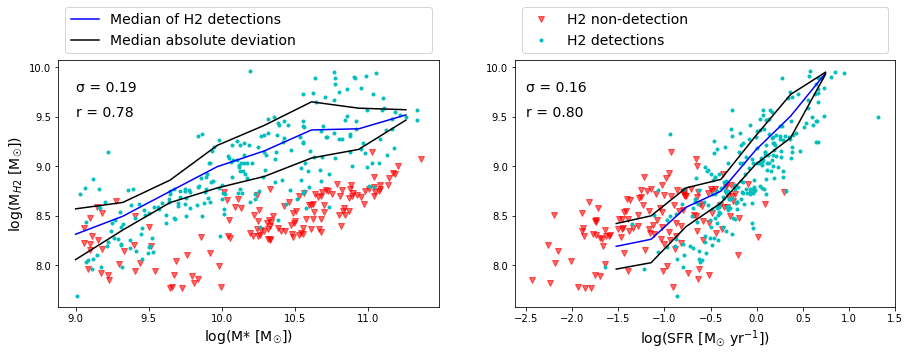

In [7]:
# Plotting the relations between the H2 mass in the galaxy and stellar mass as well as the Star formation rate
plt.figure(figsize = (15,10))
# H2 mass against Stellar mass
plt.subplot(221)
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'rv', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(H2bins[:-2], H2median1[:-2], 'b-', label = 'Median of H2 detections')
plt.plot(H2bins[:-2], H2pMAD1[:-2], 'k-', label = 'Median absolute deviation')
plt.plot(H2bins[:-2], H2nMAD1[:-2], 'k-')
plt.xlabel('log(M* [M$_{☉}$])', fontsize=14)
plt.ylabel('log(M$_{H2}$ [M$_{☉}$])', fontsize=14)
plt.text(9, 9.75, 'σ = %.2f' % ScatH2_Mstar, fontsize=14)
plt.text(9, 9.5, 'r = %.2f' % CorrH2_Mstar[1], fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)

# H2 mass against Star formation rate
plt.subplot(222)
plt.plot(lgSFRbest_ndet, limlgMH2_ndet, 'rv', alpha = 0.6, label= 'H2 non-detection')
plt.plot(lgSFRbest_det, lgMH2_det, 'c.', label= 'H2 detections')
plt.plot(H2bins2[1:-2], H2median2[1:-2], 'b-')
plt.plot(H2bins2[1:-2], H2pMAD2[1:-2], 'k-')
plt.plot(H2bins2[1:-2], H2nMAD2[1:-2], 'k-')
plt.xlabel('log(SFR [M$_{☉}$ yr$^{-1}$])', fontsize=14)
plt.text(-2.5, 9.75, 'σ = %.2f' % ScatH2_SFR, fontsize=14)
plt.text(-2.5, 9.5, 'r = %.2f' % CorrH2_SFR[1], fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14);

3) Comparing how the H2 mass changes with various stellar properties, plotted with how the global HI mass changes and how the HI mass inside the optical region changes

In [8]:
# Finding the running median of the galaxies in the sample for the HI global
# Arrays for the bins
HIglbins_Mstar = np.linspace(9, 11.5, 10)
HIglbins_NUVr = np.linspace(1, 5.5, 10)
HIglbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIglbins_Must = np.linspace(7.5, 10, 10)
HIglbins_SFR = np.linspace(-1.5, 1, 10)

# Array of zeroes to store the median of each bin
HIglmedian_Mstar = np.zeros(len(HIglbins_Mstar))
HIglMAD_Mstar = np.zeros(len(HIglbins_Mstar))

HIglmedian_NUVr = np.zeros(len(HIglbins_NUVr))
HIglMAD_NUVr = np.zeros(len(HIglbins_NUVr))

HIglmedian_sSFR = np.zeros(len(HIglbins_sSFR))
HIglMAD_sSFR = np.zeros(len(HIglbins_sSFR))

HIglmedian_Must = np.zeros(len(HIglbins_Must))
HIglMAD_Must = np.zeros(len(HIglbins_Must))

HIglmedian_SFR = np.zeros(len(HIglbins_SFR))
HIglMAD_SFR = np.zeros(len(HIglbins_SFR))

In [9]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIglbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIglmedian_Mstar[i] = np.median(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])
  HIglMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMSTAR_det >= HIglbins_Mstar[i]) & (lgMSTAR_det <= HIglbins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  HIglmedian_NUVr[i] = np.median(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])
  HIglMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((NUVr_det >= HIglbins_NUVr[i]) & (NUVr_det <= HIglbins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  HIglmedian_sSFR[i] = np.median(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])
  HIglMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgsSFR_det >= HIglbins_sSFR[i]) & (lgsSFR_det <= HIglbins_sSFR[i+1]))])

  #Median and MAD for the Must graph
  HIglmedian_Must[i] = np.median(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])
  HIglMAD_Must[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgMuST_det >= HIglbins_Must[i]) & (lgMuST_det <= HIglbins_Must[i+1]))])

  # Median and MAD for the SFR graph
  HIglmedian_SFR[i] = np.median(lgMHI_gl_det[np.where((lgSFRbest_det >= HIglbins_SFR[i]) & (lgSFRbest_det <= HIglbins_SFR[i+1]))])
  HIglMAD_SFR[i] = stats.median_abs_deviation(lgMHI_gl_det[np.where((lgSFRbest_det >= HIglbins_SFR[i]) & (lgSFRbest_det <= HIglbins_SFR[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIglpMAD_Mstar = HIglmedian_Mstar + HIglMAD_Mstar
HIglnMAD_Mstar = HIglmedian_Mstar - HIglMAD_Mstar
# NUV-r graph median bounds
HIglpMAD_NUVr = HIglmedian_NUVr + HIglMAD_NUVr
HIglnMAD_NUVr = HIglmedian_NUVr - HIglMAD_NUVr
# sSFR graph median bounds
HIglpMAD_sSFR = HIglmedian_sSFR + HIglMAD_sSFR
HIglnMAD_sSFR = HIglmedian_sSFR - HIglMAD_sSFR
# Must graph median bounds
HIglpMAD_Must = HIglmedian_Must + HIglMAD_Must
HIglnMAD_Must = HIglmedian_Must - HIglMAD_Must
# SFR graph median bounds
HIglpMAD_SFR = HIglmedian_SFR + HIglMAD_SFR
HIglnMAD_SFR = HIglmedian_SFR - HIglMAD_SFR

In [10]:
# Finding the running median of the galaxies in the sample for the HI inner
# Arrays for the bins
HIinbins_Mstar = np.linspace(9, 11.5, 10)
HIinbins_NUVr = np.linspace(1, 5.5, 10)
HIinbins_sSFR = np.linspace(-11.5, -9.5, 10)
HIinbins_Must = np.linspace(7.5, 10, 10)
HIinbins_SFR = np.linspace(-1.5, 1, 10)

# Array of zeroes to store the median of each bin
HIinmedian_Mstar = np.zeros(len(HIinbins_Mstar))
HIinMAD_Mstar = np.zeros(len(HIinbins_Mstar))

HIinmedian_NUVr = np.zeros(len(HIinbins_NUVr))
HIinMAD_NUVr = np.zeros(len(HIinbins_NUVr))

HIinmedian_sSFR = np.zeros(len(HIinbins_sSFR))
HIinMAD_sSFR = np.zeros(len(HIinbins_sSFR))

HIinmedian_Must = np.zeros(len(HIinbins_Must))
HIinMAD_Must = np.zeros(len(HIinbins_Must))

HIinmedian_SFR = np.zeros(len(HIinbins_SFR))
HIinMAD_SFR = np.zeros(len(HIinbins_SFR))

In [11]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(HIinbins_Mstar) -1):
  # Median and MAD for the Mstar graph
  HIinmedian_Mstar[i] = np.median(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])
  HIinMAD_Mstar[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMSTAR_det >= HIinbins_Mstar[i]) & (lgMSTAR_det <= HIinbins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  HIinmedian_NUVr[i] = np.median(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])
  HIinMAD_NUVr[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((NUVr_det >= HIinbins_NUVr[i]) & (NUVr_det <= HIinbins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  HIinmedian_sSFR[i] = np.median(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])
  HIinMAD_sSFR[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgsSFR_det >= HIinbins_sSFR[i]) & (lgsSFR_det <= HIinbins_sSFR[i+1]))])

  #Median and MAD for the Must graph
  HIinmedian_Must[i] = np.median(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])
  HIinMAD_Must[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgMuST_det >= HIinbins_Must[i]) & (lgMuST_det <= HIinbins_Must[i+1]))])

  # Median and MAD for the SFR graph
  HIinmedian_SFR[i] = np.median(lgMHI_in_det[np.where((lgSFRbest_det >= HIinbins_SFR[i]) & (lgSFRbest_det <= HIinbins_SFR[i+1]))])
  HIinMAD_SFR[i] = stats.median_abs_deviation(lgMHI_in_det[np.where((lgSFRbest_det >= HIinbins_SFR[i]) & (lgSFRbest_det <= HIinbins_SFR[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
HIinpMAD_Mstar = HIinmedian_Mstar + HIinMAD_Mstar
HIinnMAD_Mstar = HIinmedian_Mstar - HIinMAD_Mstar
# NUV-r graph median bounds
HIinpMAD_NUVr = HIinmedian_NUVr + HIinMAD_NUVr
HIinnMAD_NUVr = HIinmedian_NUVr - HIinMAD_NUVr
# sSFR graph median bounds
HIinpMAD_sSFR = HIinmedian_sSFR + HIinMAD_sSFR
HIinnMAD_sSFR = HIinmedian_sSFR - HIinMAD_sSFR
# Must graph median bounds
HIinpMAD_Must = HIinmedian_Must + HIinMAD_Must
HIinnMAD_Must = HIinmedian_Must - HIinMAD_Must
# SFR graph median bounds
HIinpMAD_SFR = HIinmedian_SFR + HIinMAD_SFR
HIinnMAD_SFR = HIinmedian_SFR - HIinMAD_SFR

In [12]:
# Finding the running median for the galaxies in the sample for H2
H2bins_Mstar = np.linspace(9, 11.5, 10)
H2bins_NUVr = np.linspace(1, 5.5, 10)
H2bins_sSFR = np.linspace(-11.5, -9.5, 10)
H2bins_Must = np.linspace(7.5, 10, 10)
H2bins_SFR = np.linspace(-1.5, 1, 10)

# Array of zeroes to store the median of each bin
H2median_Mstar = np.zeros(len(H2bins_Mstar))
H2MAD_Mstar = np.zeros(len(H2bins_Mstar))

H2median_NUVr = np.zeros(len(H2bins_NUVr))
H2MAD_NUVr = np.zeros(len(H2bins_NUVr))

H2median_sSFR = np.zeros(len(H2bins_sSFR))
H2MAD_sSFR = np.zeros(len(H2bins_sSFR))

H2median_Must = np.zeros(len(H2bins_Must))
H2MAD_Must = np.zeros(len(H2bins_Must))

H2median_SFR = np.zeros(len(H2bins_SFR))
H2MAD_SFR = np.zeros(len(H2bins_SFR))

In [13]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(H2bins_Mstar) -1):
  # Median and MAD for the Mstar graph
  H2median_Mstar[i] = np.median(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])
  H2MAD_Mstar[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMSTAR_det >= H2bins_Mstar[i]) & (lgMSTAR_det <= H2bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  H2median_NUVr[i] = np.median(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])
  H2MAD_NUVr[i] = stats.median_abs_deviation(lgMH2_det[np.where((NUVr_det >= H2bins_NUVr[i]) & (NUVr_det <= H2bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  H2median_sSFR[i] = np.median(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])
  H2MAD_sSFR[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgsSFR_det >= H2bins_sSFR[i]) & (lgsSFR_det <= H2bins_sSFR[i+1]))])

  #Median and MAD for the Must graph
  H2median_Must[i] = np.median(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])
  H2MAD_Must[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgMuST_det >= H2bins_Must[i]) & (lgMuST_det <= H2bins_Must[i+1]))])

  # Median and MAD for the SFR graph
  H2median_SFR[i] = np.median(lgMH2_det[np.where((lgSFRbest_det >= H2bins_SFR[i]) & (lgSFRbest_det <= H2bins_SFR[i+1]))])
  H2MAD_SFR[i] = stats.median_abs_deviation(lgMH2_det[np.where((lgSFRbest_det >= H2bins_SFR[i]) & (lgSFRbest_det <= H2bins_SFR[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
# Mstar graph median bounds
H2pMAD_Mstar = H2median_Mstar + H2MAD_Mstar
H2nMAD_Mstar = H2median_Mstar - H2MAD_Mstar
# NUV-r graph median bounds
H2pMAD_NUVr = H2median_NUVr + H2MAD_NUVr
H2nMAD_NUVr = H2median_NUVr - H2MAD_NUVr
# sSFR graph median bounds
H2pMAD_sSFR = H2median_sSFR + H2MAD_sSFR
H2nMAD_sSFR = H2median_sSFR - H2MAD_sSFR
# Must graph median bounds
H2pMAD_Must = H2median_Must + H2MAD_Must
H2nMAD_Must = H2median_Must - H2MAD_Must
# SFR graph median bounds
H2pMAD_SFR = H2median_SFR + H2MAD_SFR
H2nMAD_SFR = H2median_SFR - H2MAD_SFR

In [14]:
# Finding the scatter (difference) between the median lines and the median absolute deviation
# Average scatter of HI (global)
ScatHIgl_Mstar = np.mean(HIglMAD_Mstar[:-1])
ScatHIgl_MuST = np.mean(HIglMAD_Must[:-1])
ScatHIgl_NUVr = np.mean(HIglMAD_NUVr[:-1])
ScatHIgl_SFR = np.mean(HIglMAD_SFR[1:-1])

# Average scatter of HI (inner)
ScatHIin_Mstar = np.mean(HIinMAD_Mstar[:-1])
ScatHIin_MuST = np.mean(HIinMAD_Must[:-1])
ScatHIin_NUVr = np.mean(HIinMAD_NUVr[:-1])
ScatHIin_SFR = np.mean(HIinMAD_SFR[1:-1])

# Average scatter of H2
ScatH2_Mstar = np.mean(H2MAD_Mstar[:-1])
ScatH2_MuST = np.mean(H2MAD_Must[:-1])
ScatH2_NUVr = np.mean(H2MAD_NUVr[:-1])
ScatH2_SFR = np.mean(H2MAD_SFR[1:-1])

In [15]:
# Finding the correlation coefficient of HI (global)
CorrHIgl_Mstar = np.corrcoef(lgMSTAR_det, lgMHI_gl_det)[0]
CorrHIgl_Must = np.corrcoef(lgMuST_det, lgMHI_gl_det)[0]
CorrHIgl_NUVr = np.corrcoef(NUVr_det, lgMHI_gl_det)[0]
CorrHIgl_SFR = np.corrcoef(lgSFRbest_det, lgMHI_gl_det)[0]
# Finding the correlation coefficient of HI (inner)
CorrHIin_Mstar = np.corrcoef(lgMSTAR_det, lgMHI_in_det)[0]
CorrHIin_Must = np.corrcoef(lgMuST_det, lgMHI_in_det)[0]
CorrHIin_NUVr = np.corrcoef(NUVr_det, lgMHI_in_det)[0]
CorrHIin_SFR = np.corrcoef(lgSFRbest_det, lgMHI_in_det)[0]
# Finding the correlation coefficients of H2
CorrH2_Mstar = np.corrcoef(lgMSTAR_det, lgMH2_det)[0]
CorrH2_Must = np.corrcoef(lgMuST_det, lgMH2_det)[0]
CorrH2_NUVr = np.corrcoef(NUVr_det, lgMH2_det)[0]
CorrH2_SFR = np.corrcoef(lgSFRbest_det, lgMH2_det)[0]

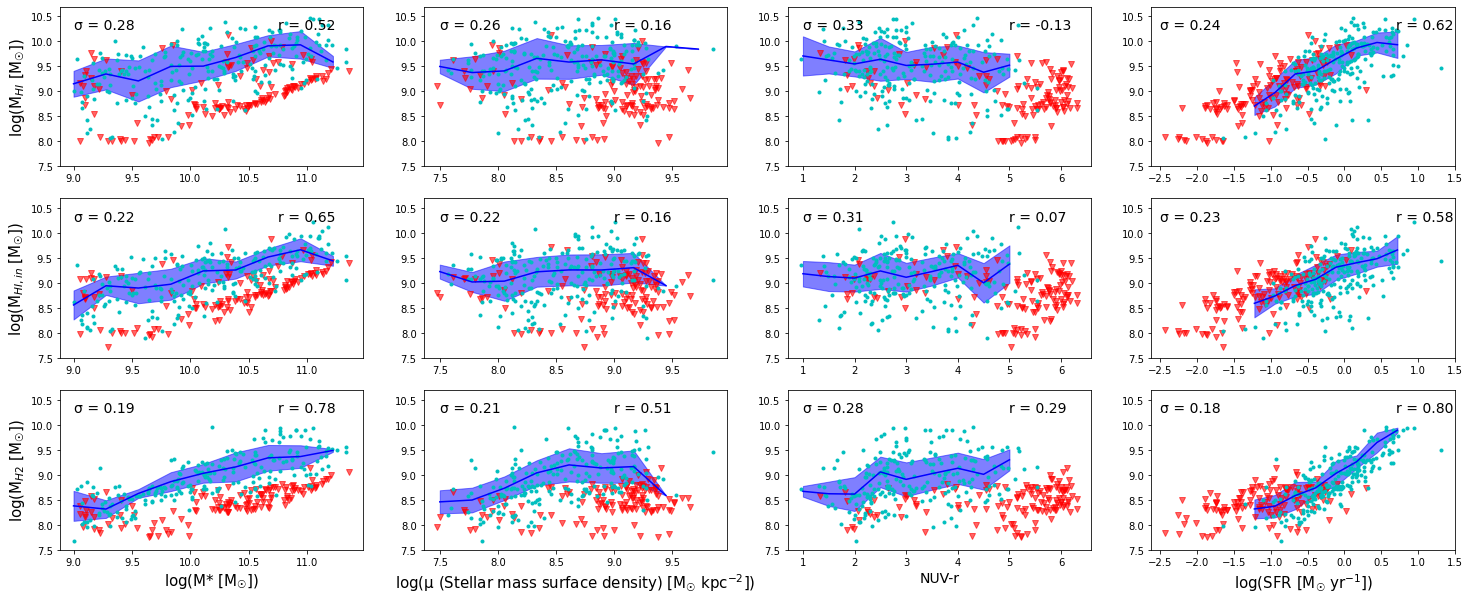

In [16]:
plt.figure(figsize=(25,10))
# Plotting the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_ndet, lgMHI_gl_ndet, 'rv', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_Mstar[:-1], HIglmedian_Mstar[:-1], 'b-')
plt.fill_between(HIglbins_Mstar[:-1], HIglnMAD_Mstar[:-1], HIglpMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{HI}$ [M$_{☉}$])', fontsize=15)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIgl_Mstar, fontsize=14)
plt.text(10.75, 10.25, 'r = %.2f' % CorrHIgl_Mstar[1], fontsize=14)
plt.ylim(7.5, 10.7)
# MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_ndet, lgMHI_gl_ndet, 'rv', alpha = 0.6)
plt.plot(lgMuST_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_Must[:-1], HIglmedian_Must[:-1], 'b-')
plt.fill_between(HIglbins_Must[:-1], HIglnMAD_Must[:-1], HIglpMAD_Must[:-1], color= 'b', alpha = 0.5)
plt.text(7.5, 10.25, 'σ = %.2f' % ScatHIgl_MuST, fontsize=14)
plt.text(9, 10.25, 'r = %.2f' % CorrHIgl_Must[1], fontsize=14)
plt.ylim(7.5, 10.7)
# MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_ndet, lgMHI_gl_ndet, 'rv', alpha = 0.6)
plt.plot(NUVr_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_NUVr[:-1], HIglmedian_NUVr[:-1], 'b-')
plt.fill_between(HIglbins_NUVr[:-1], HIglnMAD_NUVr[:-1], HIglpMAD_NUVr[:-1], color= 'b', alpha = 0.5)
plt.text(1, 10.25, 'σ = %.2f' % ScatHIgl_NUVr, fontsize=14)
plt.text(5, 10.25, 'r = %.2f' % CorrHIgl_NUVr[1], fontsize=14)
plt.ylim(7.5, 10.7)
# MHI(global) against SFR
plt.subplot(3,4,4)
plt.plot(lgSFRbest_ndet, lgMHI_gl_ndet, 'rv', alpha = 0.6)
plt.plot(lgSFRbest_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_SFR[1:-1], HIglmedian_SFR[1:-1], 'b-')
plt.fill_between(HIglbins_SFR[1:-1], HIglnMAD_SFR[1:-1], HIglpMAD_SFR[1:-1], color= 'b', alpha = 0.5)
plt.text(-2.5, 10.25, 'σ = %.2f' % ScatHIgl_SFR, fontsize=14)
plt.text(0.7, 10.25, 'r = %.2f' % CorrHIgl_SFR[1], fontsize=14)
plt.ylim(7.5, 10.7)

# Plotting HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_ndet, lgMHI_in_ndet, 'rv', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_Mstar[:-1], HIinmedian_Mstar[:-1], 'b-')
plt.fill_between(HIinbins_Mstar[:-1], HIinnMAD_Mstar[:-1], HIinpMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{HI, in}$ [M$_{☉}$])', fontsize=15)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIin_Mstar, fontsize=14)
plt.text(10.75, 10.25, 'r = %.2f' % CorrHIin_Mstar[1], fontsize=14)
plt.ylim(7.5, 10.7)
# HI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_ndet, lgMHI_in_ndet, 'rv', alpha = 0.6)
plt.plot(lgMuST_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_Must[:-2], HIinmedian_Must[:-2], 'b-')
plt.fill_between(HIinbins_Must[:-2], HIinnMAD_Must[:-2], HIinpMAD_Must[:-2], color= 'b', alpha = 0.5)
plt.text(7.5, 10.25, 'σ = %.2f' % ScatHIin_MuST, fontsize=14)
plt.text(9, 10.25, 'r = %.2f' % CorrHIin_Must[1], fontsize=14)
plt.ylim(7.5, 10.7)
# HI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_ndet, lgMHI_in_ndet, 'rv', alpha = 0.6)
plt.plot(NUVr_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_NUVr[:-1], HIinmedian_NUVr[:-1], 'b-')
plt.fill_between(HIinbins_NUVr[:-1], HIinnMAD_NUVr[:-1], HIinpMAD_NUVr[:-1], color= 'b', alpha = 0.5)
plt.text(1, 10.25, 'σ = %.2f' % ScatHIin_NUVr, fontsize=14)
plt.text(5, 10.25, 'r = %.2f' % CorrHIin_NUVr[1], fontsize=14)
plt.ylim(7.5, 10.7)
# HI(in) against SFR
plt.subplot(3,4,8)
plt.plot(lgSFRbest_ndet, lgMHI_in_ndet, 'rv', alpha = 0.6)
plt.plot(lgSFRbest_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_SFR[1:-1], HIinmedian_SFR[1:-1], 'b-')
plt.fill_between(HIinbins_SFR[1:-1], HIinnMAD_SFR[1:-1], HIinpMAD_SFR[1:-1], color= 'b', alpha = 0.5)
plt.text(-2.5, 10.25, 'σ = %.2f' % ScatHIin_SFR, fontsize=14)
plt.text(0.7, 10.25, 'r = %.2f' % CorrHIin_SFR[1], fontsize=14)
plt.ylim(7.5, 10.7)

# Plotting the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'rv', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(H2bins_Mstar[:-1], H2median_Mstar[:-1], 'b-')
plt.fill_between(H2bins_Mstar[:-1], H2nMAD_Mstar[:-1], H2pMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{H2}$ [M$_{☉}$])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.text(9, 10.25, 'σ = %.2f' % ScatH2_Mstar, fontsize=14)
plt.text(10.75, 10.25, 'r = %.2f' % CorrH2_Mstar[1], fontsize=14)
plt.ylim(7.5, 10.7)
# H2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_ndet, limlgMH2_ndet, 'rv', alpha = 0.6)
plt.plot(lgMuST_det, lgMH2_det, 'c.')
plt.plot(H2bins_Must[:-2], H2median_Must[:-2], 'b-')
plt.fill_between(H2bins_Must[:-2], H2nMAD_Must[:-2], H2pMAD_Must[:-2], color= 'b', alpha = 0.5)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{☉}$ kpc$^{-2}$])', fontsize=15)
plt.text(7.5, 10.25, 'σ = %.2f' % ScatH2_MuST, fontsize=14)
plt.text(9, 10.25, 'r = %.2f' % CorrH2_Must[1], fontsize=14)
plt.ylim(7.5, 10.7)
# H2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_ndet, limlgMH2_ndet, 'rv', alpha = 0.6)
plt.plot(NUVr_det, lgMH2_det, 'c.')
plt.plot(H2bins_NUVr[:-1], H2median_NUVr[:-1], 'b-')
plt.fill_between(H2bins_NUVr[:-1], H2nMAD_NUVr[:-1], H2pMAD_NUVr[:-1], color= 'b', alpha = 0.5)
plt.xlabel('NUV-r', fontsize=14)
plt.text(1, 10.25, 'σ = %.2f' % ScatH2_NUVr, fontsize=14)
plt.text(5, 10.25, 'r = %.2f' % CorrH2_NUVr[1], fontsize=14)
plt.ylim(7.5, 10.7)
# H2 against SFR
plt.subplot(3,4,12)
plt.plot(lgSFRbest_ndet, limlgMH2_ndet, 'rv', alpha = 0.6)
plt.plot(lgSFRbest_det, lgMH2_det, 'c.')
plt.plot(H2bins_SFR[1:-1], H2median_SFR[1:-1], 'b-')
plt.fill_between(H2bins_SFR[1:-1], H2nMAD_SFR[1:-1], H2pMAD_SFR[1:-1], color= 'b', alpha = 0.5)
plt.xlabel('log(SFR [M$_{☉}$ yr$^{-1}$])', fontsize=15)
plt.text(-2.5, 10.25, 'σ = %.2f' % ScatH2_SFR, fontsize=14)
plt.text(0.7, 10.25, 'r = %.2f' % CorrH2_SFR[1], fontsize=14)
plt.ylim(7.5, 10.7);

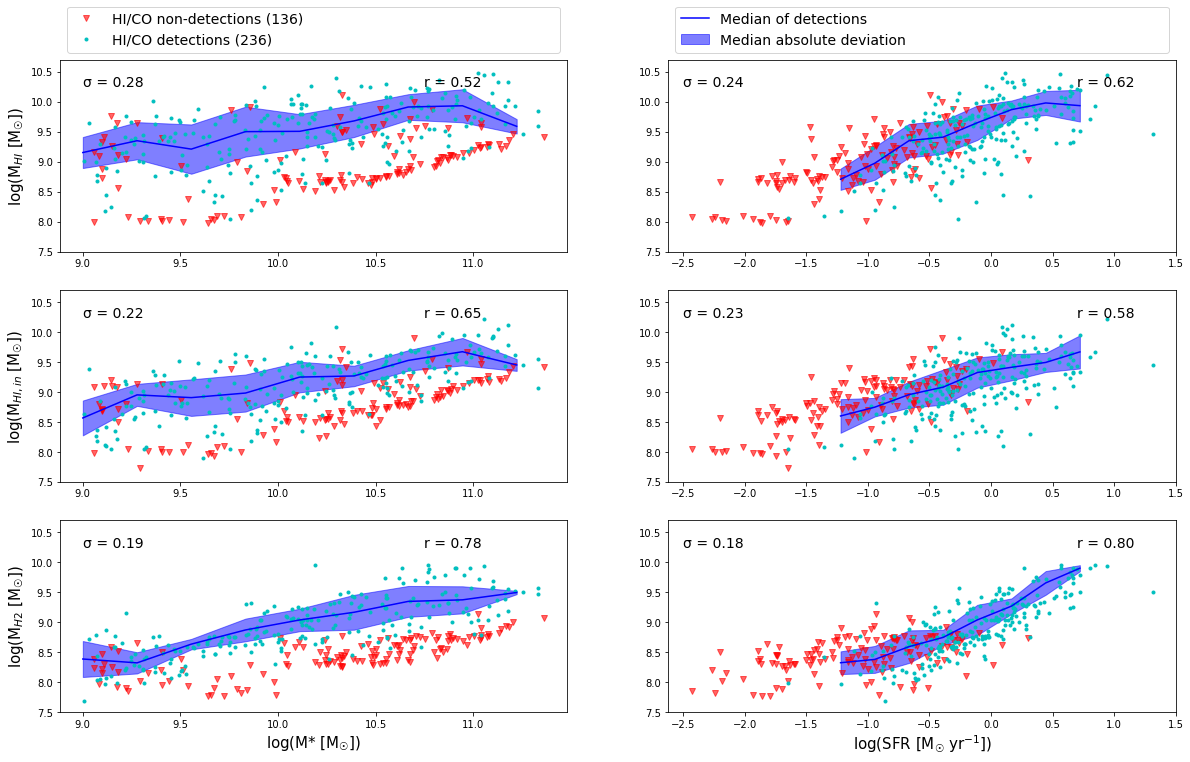

In [17]:
plt.figure(figsize=(20,12))
# Plotting the HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,2,1)
plt.plot(lgMSTAR_ndet, lgMHI_gl_ndet, 'rv', alpha = 0.6, label='HI/CO non-detections (136)')
plt.plot(lgMSTAR_det, lgMHI_gl_det, 'c.', label='HI/CO detections (236)')
plt.plot(HIglbins_Mstar[:-1], HIglmedian_Mstar[:-1], 'b-')
plt.fill_between(HIglbins_Mstar[:-1], HIglnMAD_Mstar[:-1], HIglpMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{HI}$ [M$_{☉}$])', fontsize=15)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIgl_Mstar, fontsize=14)
plt.text(10.75, 10.25, 'r = %.2f' % CorrHIgl_Mstar[1], fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.ylim(7.5, 10.7)
# MHI(global) against SFR
plt.subplot(3,2,2)
plt.plot(lgSFRbest_ndet, lgMHI_gl_ndet, 'rv', alpha = 0.6)
plt.plot(lgSFRbest_det, lgMHI_gl_det, 'c.')
plt.plot(HIglbins_SFR[1:-1], HIglmedian_SFR[1:-1], 'b-', label='Median of detections')
plt.fill_between(HIglbins_SFR[1:-1], HIglnMAD_SFR[1:-1], HIglpMAD_SFR[1:-1], color= 'b', alpha = 0.5, label='Median absolute deviation')
plt.text(-2.5, 10.25, 'σ = %.2f' % ScatHIgl_SFR, fontsize=14)
plt.text(0.7, 10.25, 'r = %.2f' % CorrHIgl_SFR[1], fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.ylim(7.5, 10.7)

# Plotting HI(in) mass against stellar properties
# HI(in) against stellar mass
plt.subplot(3,2,3)
plt.plot(lgMSTAR_ndet, lgMHI_in_ndet, 'rv', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_Mstar[:-1], HIinmedian_Mstar[:-1], 'b-')
plt.fill_between(HIinbins_Mstar[:-1], HIinnMAD_Mstar[:-1], HIinpMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{HI, in}$ [M$_{☉}$])', fontsize=15)
plt.text(9, 10.25, 'σ = %.2f' % ScatHIin_Mstar, fontsize=14)
plt.text(10.75, 10.25, 'r = %.2f' % CorrHIin_Mstar[1], fontsize=14)
plt.ylim(7.5, 10.7)
# HI(in) against SFR
plt.subplot(3,2,4)
plt.plot(lgSFRbest_ndet, lgMHI_in_ndet, 'rv', alpha = 0.6)
plt.plot(lgSFRbest_det, lgMHI_in_det, 'c.')
plt.plot(HIinbins_SFR[1:-1], HIinmedian_SFR[1:-1], 'b-')
plt.fill_between(HIinbins_SFR[1:-1], HIinnMAD_SFR[1:-1], HIinpMAD_SFR[1:-1], color= 'b', alpha = 0.5)
plt.text(-2.5, 10.25, 'σ = %.2f' % ScatHIin_SFR, fontsize=14)
plt.text(0.7, 10.25, 'r = %.2f' % CorrHIin_SFR[1], fontsize=14)
plt.ylim(7.5, 10.7)

# Plotting the H2 mass against stellar properties
# H2 against stellar mass
plt.subplot(3,2,5)
plt.plot(lgMSTAR_ndet, limlgMH2_ndet, 'rv', alpha = 0.6)
plt.plot(lgMSTAR_det, lgMH2_det, 'c.')
plt.plot(H2bins_Mstar[:-1], H2median_Mstar[:-1], 'b-')
plt.fill_between(H2bins_Mstar[:-1], H2nMAD_Mstar[:-1], H2pMAD_Mstar[:-1], color= 'b', alpha = 0.5)
plt.ylabel('log(M$_{H2}$ [M$_{☉}$])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.text(9, 10.25, 'σ = %.2f' % ScatH2_Mstar, fontsize=14)
plt.text(10.75, 10.25, 'r = %.2f' % CorrH2_Mstar[1], fontsize=14)
plt.ylim(7.5, 10.7)
# H2 against SFR
plt.subplot(3,2,6)
plt.plot(lgSFRbest_ndet, limlgMH2_ndet, 'rv', alpha = 0.6)
plt.plot(lgSFRbest_det, lgMH2_det, 'c.')
plt.plot(H2bins_SFR[1:-1], H2median_SFR[1:-1], 'b-')
plt.fill_between(H2bins_SFR[1:-1], H2nMAD_SFR[1:-1], H2pMAD_SFR[1:-1], color= 'b', alpha = 0.5)
plt.xlabel('log(SFR [M$_{☉}$ yr$^{-1}$])', fontsize=15)
plt.text(-2.5, 10.25, 'σ = %.2f' % ScatH2_SFR, fontsize=14)
plt.text(0.7, 10.25, 'r = %.2f' % CorrH2_SFR[1], fontsize=14)
plt.ylim(7.5, 10.7);

4) Investigating how the trends are affected by the binning the bulge-to-total ratio- plotting trends for the spiral dominated galaxies and then for the total of the sample

In [18]:
# Finding the distribution of galaxies in the bulge-to-total sample
print('B/T > 0.6:', len(np.where(B2TM > 0.6)[0]))
print('B/T > 0.4:', len(np.where(B2TM > 0.4)[0]))
print('B/T > 0.2:', len(np.where(B2TM > 0.2)[0]))
print('B/T > 0.1:', len(np.where(B2TM > 0.1)[0]))

B/T > 0.6: 16
B/T > 0.4: 64
B/T > 0.2: 167
B/T > 0.1: 222


In [19]:
# Due to the large number of galaxies dominated by a disk component need to change the bins to focus more of those galaxies
# Over half the galaxies present in the sample are between 0 and 0.2 on the bulge-to-total ratio
lgMH2_tot = lgMH2 + limlgMH2
B2TM1 = B2TM[np.where(B2TM < 0.2)]
B2TM2 = B2TM[np.where((B2TM > 0.2) & (B2TM < 0.4))]
B2TM3 = B2TM[np.where(B2TM > 0.4)]

lgMHI_in1 = lgMHI_in[np.where(B2TM < 0.2)]
lgMHI_in2 = lgMHI_in[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_in3 = lgMHI_in[np.where(B2TM > 0.4)]

lgMHI_gl1 = lgMHI_gl[np.where(B2TM < 0.2)]
lgMHI_gl2 = lgMHI_gl[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMHI_gl3 = lgMHI_gl[np.where(B2TM > 0.4)]

lgMH2_tot1 = lgMH2_tot[np.where(B2TM < 0.2)]
lgMH2_tot2 = lgMH2_tot[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMH2_tot3 = lgMH2_tot[np.where(B2TM > 0.4)]

lgMSTAR1 = lgMSTAR[np.where(B2TM < 0.2)]
lgMSTAR2 = lgMSTAR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMSTAR3 = lgMSTAR[np.where(B2TM > 0.4)]

NUVr1 = NUVr[np.where(B2TM < 0.2)]
NUVr2 = NUVr[np.where((B2TM > 0.2) & (B2TM < 0.4))]
NUVr3 = NUVr[np.where(B2TM > 0.4)]

lgsSFR1 = lgsSFR[np.where(B2TM < 0.2)]
lgsSFR2 = lgsSFR[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgsSFR3 = lgsSFR[np.where(B2TM > 0.4)]

lgMuST1 = lgMuST[np.where(B2TM < 0.2)]
lgMuST2 = lgMuST[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgMuST3 = lgMuST[np.where(B2TM > 0.4)]

HIsrc1 = HIsrc[np.where(B2TM < 0.2)]
HIsrc2 = HIsrc[np.where((B2TM > 0.2) & (B2TM < 0.4))]
HIsrc3 = HIsrc[np.where(B2TM > 0.4)]

FLAG_CO1 = FLAG_CO[np.where(B2TM < 0.2)]
FLAG_CO2 = FLAG_CO[np.where((B2TM > 0.2) & (B2TM < 0.4))]
FLAG_CO3 = FLAG_CO[np.where(B2TM > 0.4)]

lgSFRbest1 = lgSFRbest[np.where(B2TM < 0.2)]
lgSFRbest2 = lgSFRbest[np.where((B2TM > 0.2) & (B2TM < 0.4))]
lgSFRbest3 = lgSFRbest[np.where(B2TM > 0.4)]

5) Comparison of how the mass of HI (global) and the mass of HI (interior) compare with the mass of the H2

In [20]:
# We have four cases of detections vs non-detections:
# (1) HI flag is 1,2,3- a detection AND CO flag is 1- a detection
# (2) HI flag is 4- a non-detection AND CO flag is 2- a non-detection
# (3) HI flag is 1,2,3- detection AND CO flag is 2- a non detection
# (4) HI flag is 4- a non-detection AND CO flag is 1- a detection
# For the scaling relations of MH2/MHI(in) and MH2/MHI(global):
# Case (1) are galaxies detections
# Case (2) are galaxy non-detections and must be removed from the sample
# Case (3) are upper limits
# Case (4) are the lower limits

# Finding the amount of galaxies that fit each criteria, each will be suffixed by a 1,2,3,4 based on the definitions above:
# HI (global) mass
lgMHI_gl_det1 = lgMHI_gl[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMHI_gl_det2 = lgMHI_gl[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMHI_gl_det3 = lgMHI_gl[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMHI_gl_det4 = lgMHI_gl[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# HI (inner) mass
lgMHI_in_det1 = lgMHI_in[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMHI_in_det2 = lgMHI_in[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMHI_in_det3 = lgMHI_in[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMHI_in_det4 = lgMHI_in[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# H2 mass
lgMH2_det1 = lgMH2_tot[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMH2_det2 = lgMH2_tot[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMH2_det3 = lgMH2_tot[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMH2_det4 = lgMH2_tot[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# Stellar mass
lgMSTAR_det1 = lgMSTAR[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMSTAR_det2 = lgMSTAR[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMSTAR_det3 = lgMSTAR[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMSTAR_det4 = lgMSTAR[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# Stellar mass surface density
lgMuST_det1 = lgMuST[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgMuST_det2 = lgMuST[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgMuST_det3 = lgMuST[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgMuST_det4 = lgMuST[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# NUVr
NUVr_det1 = NUVr[np.where((HIsrc < 4) & (FLAG_CO < 2))]
NUVr_det2 = NUVr[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
NUVr_det3 = NUVr[np.where((HIsrc < 4) & (FLAG_CO > 1))]
NUVr_det4 = NUVr[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# sSFR
lgsSFR_det1 = lgsSFR[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgsSFR_det2 = lgsSFR[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgsSFR_det3 = lgsSFR[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgsSFR_det4 = lgsSFR[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# B2TM
B2TM_det1 = B2TM[np.where((HIsrc < 4) & (FLAG_CO < 2))]
B2TM_det2 = B2TM[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
B2TM_det3 = B2TM[np.where((HIsrc < 4) & (FLAG_CO > 1))]
B2TM_det4 = B2TM[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# SFR
lgSFRbest_det1 = lgSFRbest[np.where((HIsrc < 4) & (FLAG_CO < 2))]
lgSFRbest_det2 = lgSFRbest[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
lgSFRbest_det3 = lgSFRbest[np.where((HIsrc < 4) & (FLAG_CO > 1))]
lgSFRbest_det4 = lgSFRbest[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# GASS ID
GASS_det1 = GASS[np.where((HIsrc < 4) & (FLAG_CO < 2))]
GASS_det2 = GASS[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
GASS_det3 = GASS[np.where((HIsrc < 4) & (FLAG_CO > 1))]
GASS_det4 = GASS[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# RA
RA_det1 = RA[np.where((HIsrc < 4) & (FLAG_CO < 2))]
RA_det2 = RA[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
RA_det3 = RA[np.where((HIsrc < 4) & (FLAG_CO > 1))]
RA_det4 = RA[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# DEC
DEC_det1 = DEC[np.where((HIsrc < 4) & (FLAG_CO < 2))]
DEC_det2 = DEC[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
DEC_det3 = DEC[np.where((HIsrc < 4) & (FLAG_CO > 1))]
DEC_det4 = DEC[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# 2Reff
Reff_kpc_det1 = Reff_kpc[np.where((HIsrc < 4) & (FLAG_CO < 2))]
Reff_kpc_det2 = Reff_kpc[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
Reff_kpc_det3 = Reff_kpc[np.where((HIsrc < 4) & (FLAG_CO > 1))]
Reff_kpc_det4 = Reff_kpc[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# R90
R90_kpc_det1 = R90_kpc[np.where((HIsrc < 4) & (FLAG_CO < 2))]
R90_kpc_det2 = R90_kpc[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
R90_kpc_det3 = R90_kpc[np.where((HIsrc < 4) & (FLAG_CO > 1))]
R90_kpc_det4 = R90_kpc[np.where((HIsrc >= 4) & (FLAG_CO < 2))]
# RHI
RHI_kpc_det1 = RHI_kpc[np.where((HIsrc < 4) & (FLAG_CO < 2))]
RHI_kpc_det2 = RHI_kpc[np.where((HIsrc >= 4) & (FLAG_CO > 1))]
RHI_kpc_det3 = RHI_kpc[np.where((HIsrc < 4) & (FLAG_CO > 1))]
RHI_kpc_det4 = RHI_kpc[np.where((HIsrc >= 4) & (FLAG_CO < 2))]

In [21]:
# We can now compute the mass fractions, ignoring any variable with a '2' suffix
# H2/HI(global)
H2HIgl_det1 = np.log10((10**lgMH2_det1) / (10**lgMHI_gl_det1))
H2HIgl_det3 = np.log10((10**lgMH2_det3) / (10**lgMHI_gl_det3))
H2HIgl_det4 = np.log10((10**lgMH2_det4) / (10**lgMHI_gl_det4))
# H2/HI(inner)
H2HIin_det1 = np.log10((10**lgMH2_det1) / (10**lgMHI_in_det1))
H2HIin_det3 = np.log10((10**lgMH2_det3) / (10**lgMHI_in_det3))
H2HIin_det4 = np.log10((10**lgMH2_det4) / (10**lgMHI_in_det4))

In [22]:
# Finding the running median of the galaxies in the sample for the H2/HI(global)
# Arrays for the bins
bins_Mstar = np.linspace(9.25, 11, 10)
bins_NUVr = np.linspace(1.5, 7.5, 10)
bins_sSFR = np.linspace(-11.15, -9.25, 10)
bins_Must = np.linspace(7.75, 9.4, 10)

# Array of zeroes to store the median of each bin
H2HIgl_median_Mstar = np.zeros(len(bins_Mstar)) 
H2HIgl_MAD_Mstar = np.zeros(len(bins_Mstar))

H2HIgl_median_NUVr = np.zeros(len(bins_NUVr))
H2HIgl_MAD_NUVr = np.zeros(len(bins_NUVr))

H2HIgl_median_sSFR = np.zeros(len(bins_sSFR))
H2HIgl_MAD_sSFR = np.zeros(len(bins_sSFR))

H2HIgl_median_Must = np.zeros(len(bins_Must))
H2HIgl_MAD_Must = np.zeros(len(bins_Must))

In [23]:
# Finding the running median of the galaxies in the sample for the H2/HI(inner)
# Arrays for the zeros to store the median of each bin
H2HIin_median_Mstar = np.zeros(len(bins_Mstar)) 
H2HIin_MAD_Mstar = np.zeros(len(bins_Mstar))

H2HIin_median_NUVr = np.zeros(len(bins_NUVr))
H2HIin_MAD_NUVr = np.zeros(len(bins_NUVr))

H2HIin_median_sSFR = np.zeros(len(bins_sSFR))
H2HIin_MAD_sSFR = np.zeros(len(bins_sSFR))

H2HIin_median_Must = np.zeros(len(bins_Must))
H2HIin_MAD_Must = np.zeros(len(bins_Must))

In [24]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # H2/HI (global)
  # Median and MAD for the Mstar graph
  H2HIgl_median_Mstar[i] = np.median(H2HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  H2HIgl_MAD_Mstar[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  H2HIgl_median_NUVr[i] = np.median(H2HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  H2HIgl_MAD_NUVr[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  H2HIgl_median_sSFR[i] = np.median(H2HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  H2HIgl_MAD_sSFR[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  H2HIgl_median_Must[i] = np.median(H2HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  H2HIgl_MAD_Must[i] = stats.median_abs_deviation(H2HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

  # H2/HI (optical)
  # Median and MAD for the Mstar graph
  H2HIin_median_Mstar[i] = np.median(H2HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  H2HIin_MAD_Mstar[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  H2HIin_median_NUVr[i] = np.median(H2HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  H2HIin_MAD_NUVr[i] = stats.median_abs_deviation(H2HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  H2HIin_median_sSFR[i] = np.median(H2HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  H2HIin_MAD_sSFR[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  H2HIin_median_Must[i] = np.median(H2HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  H2HIin_MAD_Must[i] = stats.median_abs_deviation(H2HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
# H2/HI (global)
# Mstar graph median bounds
H2HIgl_pMAD_Mstar = H2HIgl_median_Mstar + H2HIgl_MAD_Mstar
H2HIgl_nMAD_Mstar = H2HIgl_median_Mstar - H2HIgl_MAD_Mstar
# NUV-r graph median bounds
H2HIgl_pMAD_NUVr = H2HIgl_median_NUVr + H2HIgl_MAD_NUVr
H2HIgl_nMAD_NUVr = H2HIgl_median_NUVr - H2HIgl_MAD_NUVr
# sSFR graph median bounds
H2HIgl_pMAD_sSFR = H2HIgl_median_sSFR + H2HIgl_MAD_sSFR
H2HIgl_nMAD_sSFR = H2HIgl_median_sSFR - H2HIgl_MAD_sSFR
# Must graph median bounds
H2HIgl_pMAD_Must = H2HIgl_median_Must + H2HIgl_MAD_Must
H2HIgl_nMAD_Must = H2HIgl_median_Must - H2HIgl_MAD_Must

# H2/HI (optical)
# Mstar graph median bounds
H2HIin_pMAD_Mstar = H2HIin_median_Mstar + H2HIin_MAD_Mstar
H2HIin_nMAD_Mstar = H2HIin_median_Mstar - H2HIin_MAD_Mstar
# NUV-r graph median bounds
H2HIin_pMAD_NUVr = H2HIin_median_NUVr + H2HIin_MAD_NUVr
H2HIin_nMAD_NUVr = H2HIin_median_NUVr - H2HIin_MAD_NUVr
# sSFR graph median bounds
H2HIin_pMAD_sSFR = H2HIin_median_sSFR + H2HIin_MAD_sSFR
H2HIin_nMAD_sSFR = H2HIin_median_sSFR - H2HIin_MAD_sSFR
# Must graph median bounds
H2HIin_pMAD_Must = H2HIin_median_Must + H2HIin_MAD_Must
H2HIin_nMAD_Must = H2HIin_median_Must - H2HIin_MAD_Must

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
# Finding the average scatter of the detections on each plot, mean of the MAD values for each plot:
# H2/HI (global)
ScatH2HIgl_Mstar = np.mean(H2HIgl_MAD_Mstar[:-1])
ScatH2HIgl_NUVr = np.mean(H2HIgl_MAD_NUVr[:-4])
ScatH2HIgl_sSFR = np.mean(H2HIgl_MAD_sSFR[:-2])
ScatH2HIgl_Must = np.mean(H2HIgl_MAD_Must[:-1])
# H2/HI (optical)
ScatH2HIin_Mstar = np.mean(H2HIin_MAD_Mstar[:-1])
ScatH2HIin_NUVr = np.mean(H2HIin_MAD_NUVr[:-4])
ScatH2HIin_sSFR = np.mean(H2HIin_MAD_sSFR[:-2])
ScatH2HIin_Must = np.mean(H2HIin_MAD_Must[:-1])

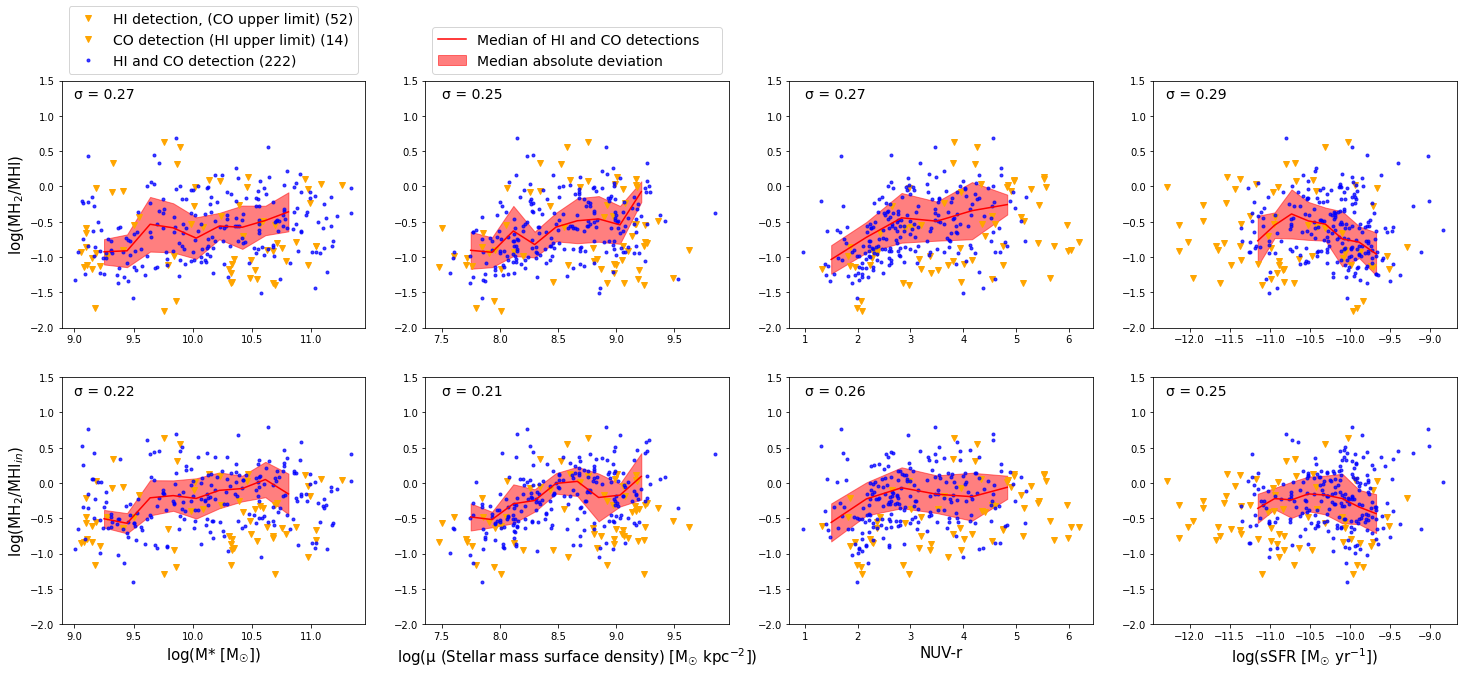

In [26]:
# Plotting the mass fractions against the four stellar properties seen before
plt.figure(figsize=(25,10))
# H2/HI(global) stellar mass
plt.subplot(2,4,1)
plt.plot(lgMSTAR_det3, H2HIgl_det3, 'orange', marker = 'v', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgMSTAR_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgMSTAR_det1, H2HIgl_det1, 'blue', marker = '.', linestyle ='none', alpha = 0.75, label='HI and CO detection (222)')
plt.ylabel('log(MH$_{2}$/MHI)', fontsize=15)
plt.plot(bins_Mstar[:-1], H2HIgl_median_Mstar[:-1], 'r-')
plt.fill_between(bins_Mstar[:-1], H2HIgl_nMAD_Mstar[:-1], H2HIgl_pMAD_Mstar[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.text(9, 1.25, 'σ = %.2f' % ScatH2HIgl_Mstar, fontsize=14)
# H2/HI(global) stellar surface density
plt.subplot(2,4,2)
plt.plot(lgMuST_det3, H2HIgl_det3, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_Must[:-1], H2HIgl_median_Must[:-1], 'r-', label='Median of HI and CO detections')
plt.fill_between(bins_Must[:-1], H2HIgl_nMAD_Must[:-1], H2HIgl_pMAD_Must[:-1], color= 'r', alpha = 0.5, label='Median absolute deviation')
plt.ylim(-2, 1.5)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.text(7.5, 1.25, 'σ = %.2f' % ScatH2HIgl_Must, fontsize=14)
# H2/HI(global) NUVr
plt.subplot(2,4,3)
plt.plot(NUVr_det3, H2HIgl_det3, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_NUVr[:-1], H2HIgl_median_NUVr[:-1], 'r-')
plt.fill_between(bins_NUVr[:-1], H2HIgl_nMAD_NUVr[:-1], H2HIgl_pMAD_NUVr[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(1, 1.25, 'σ = %.2f' % ScatH2HIgl_NUVr, fontsize=14)
# H2/HI(global) sSFR
plt.subplot(2,4,4)
plt.plot(lgsSFR_det3, H2HIgl_det3, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det4, H2HIgl_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det1, H2HIgl_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.plot(bins_sSFR[:-2], H2HIgl_median_sSFR[:-2], 'r-')
plt.fill_between(bins_sSFR[:-2], H2HIgl_nMAD_sSFR[:-2], H2HIgl_pMAD_sSFR[:-2], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(-12.3, 1.25, 'σ = %.2f' % ScatH2HIgl_sSFR, fontsize=14)

# H2/HI(inner) stellar mass
plt.subplot(2,4,5)
plt.plot(lgMSTAR_det3, H2HIin_det3, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.ylabel('log(MH$_{2}$/MHI$_{in}$)', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.plot(bins_Mstar[:-1], H2HIin_median_Mstar[:-1], 'r-')
plt.fill_between(bins_Mstar[:-1], H2HIin_nMAD_Mstar[:-1], H2HIin_pMAD_Mstar[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(9, 1.25, 'σ = %.2f' % ScatH2HIin_Mstar, fontsize=14)
# H2/HI(inner) stellar surface density
plt.subplot(2,4,6)
plt.plot(lgMuST_det3, H2HIin_det3, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgMuST_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{☉}$ kpc$^{-2}$])', fontsize=15)
plt.plot(bins_Must[:-1], H2HIin_median_Must[:-1], 'r-')
plt.fill_between(bins_Must[:-1], H2HIin_nMAD_Must[:-1], H2HIin_pMAD_Must[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(7.5, 1.25, 'σ = %.2f' % ScatH2HIin_Must, fontsize=14)
# H2/HI(inner) NUVr
plt.subplot(2,4,7)
plt.plot(NUVr_det3, H2HIin_det3, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(NUVr_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('NUV-r', fontsize=15)
plt.plot(bins_NUVr[:-1], H2HIin_median_NUVr[:-1], 'r-')
plt.fill_between(bins_NUVr[:-1], H2HIin_nMAD_NUVr[:-1], H2HIin_pMAD_NUVr[:-1], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(1, 1.25, 'σ = %.2f' % ScatH2HIin_NUVr, fontsize=14)
# H2/HI(inner) sSFR
plt.subplot(2,4,8)
plt.plot(lgsSFR_det3, H2HIin_det3, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det4, H2HIin_det4, 'orange', marker = 'v', linestyle='none')
plt.plot(lgsSFR_det1, H2HIin_det1, 'blue', marker = '.', linestyle='none', alpha = 0.75)
plt.xlabel('log(sSFR [M$_{☉}$ yr$^{-1}$])', fontsize=15)
plt.plot(bins_sSFR[:-2], H2HIin_median_sSFR[:-2], 'r-')
plt.fill_between(bins_sSFR[:-2], H2HIin_nMAD_sSFR[:-2], H2HIin_pMAD_sSFR[:-2], color= 'r', alpha = 0.5)
plt.ylim(-2, 1.5)
plt.text(-12.3, 1.25, 'σ = %.2f' % ScatH2HIin_sSFR, fontsize=14);

6) Looking at the depletion time for the gases

In [27]:
# Depletion times are given by t(dep) = M(gas)/SFR
# Depletion time for HI (global, detections)
lgtdep_HIgl_det1 = np.log10((10**lgMHI_gl_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for HI (global, upper and lower limits)
lgtdep_HIgl_det3 = np.log10((10**lgMHI_gl_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_HIgl_det4 = np.log10((10**lgMHI_gl_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

# Depletion time for HI (optical, detections)
lgtdep_HIin_det1 = np.log10((10**lgMHI_in_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for HI (optical, upper and lower limits)
lgtdep_HIin_det3 = np.log10((10**lgMHI_in_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_HIin_det4 = np.log10((10**lgMHI_in_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

# Depletion time for H2 (detections)
lgtdep_H2_det1 = np.log10((10**lgMH2_det1) / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
# Depletion time for H2 (upper and lower limits)
lgtdep_H2_det3 = np.log10((10**lgMH2_det3) / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_H2_det4 = np.log10((10**lgMH2_det4) / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

In [28]:
# Finding the running median of the galaxies in the sample for the HI global
# Arrays for the bins
bins_Mstar = np.linspace(9, 11.25, 10)
bins_NUVr = np.linspace(1, 5.5, 10)
bins_sSFR = np.linspace(-11.25, -9.5, 10)
bins_Must = np.linspace(7.5, 9.5, 10)

In [29]:
# Array of zeroes to store the median of each bin
# Depletion times for HI (global)
tdep_HIglmedian_Mstar = np.zeros(len(bins_Mstar))
tdep_HIglMAD_Mstar = np.zeros(len(bins_Mstar))

tdep_HIglmedian_NUVr = np.zeros(len(bins_NUVr))
tdep_HIglMAD_NUVr = np.zeros(len(bins_NUVr))

tdep_HIglmedian_sSFR = np.zeros(len(bins_sSFR))
tdep_HIglMAD_sSFR = np.zeros(len(bins_sSFR))

tdep_HIglmedian_Must = np.zeros(len(bins_Must))
tdep_HIglMAD_Must = np.zeros(len(bins_Must))

# Depletion times for HI (optical)
tdep_HIinmedian_Mstar = np.zeros(len(bins_Mstar))
tdep_HIinMAD_Mstar = np.zeros(len(bins_Mstar))

tdep_HIinmedian_NUVr = np.zeros(len(bins_NUVr))
tdep_HIinMAD_NUVr = np.zeros(len(bins_NUVr))

tdep_HIinmedian_sSFR = np.zeros(len(bins_sSFR))
tdep_HIinMAD_sSFR = np.zeros(len(bins_sSFR))

tdep_HIinmedian_Must = np.zeros(len(bins_Must))
tdep_HIinMAD_Must = np.zeros(len(bins_Must))

# Depletion time for H2
tdep_H2median_Mstar = np.zeros(len(bins_Mstar))
tdep_H2MAD_Mstar = np.zeros(len(H2bins_Mstar))

tdep_H2median_NUVr = np.zeros(len(bins_NUVr))
tdep_H2MAD_NUVr = np.zeros(len(bins_NUVr))

tdep_H2median_sSFR = np.zeros(len(bins_sSFR))
tdep_H2MAD_sSFR = np.zeros(len(bins_sSFR))

tdep_H2median_Must = np.zeros(len(bins_Must))
tdep_H2MAD_Must = np.zeros(len(bins_Must))

In [30]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar) -1):
  # Depletion time of HI (global)
  # Median and MAD for the Mstar graph
  tdep_HIglmedian_Mstar[i] = np.median(lgtdep_HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_HIglMAD_Mstar[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIglmedian_NUVr[i] = np.median(lgtdep_HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_HIglMAD_NUVr[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIglmedian_sSFR[i] = np.median(lgtdep_HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_HIglMAD_sSFR[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])

  # Median and MAD for the Must graph
  tdep_HIglmedian_Must[i] = np.median(lgtdep_HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_HIglMAD_Must[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

  # Depletion time of HI (optical)
  # Median and MAD for the Mstar graph
  tdep_HIinmedian_Mstar[i] = np.median(lgtdep_HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_HIinMAD_Mstar[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIinmedian_NUVr[i] = np.median(lgtdep_HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_HIinMAD_NUVr[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIinmedian_sSFR[i] = np.median(lgtdep_HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_HIinMAD_sSFR[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_HIinmedian_Must[i] = np.median(lgtdep_HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_HIinMAD_Must[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  
  # Depletion time of H2
  # Median and MAD for the Mstar graph
  tdep_H2median_Mstar[i] = np.median(lgtdep_H2_det1[np.where((lgMSTAR_det1 >= bins_Mstar[i]) & (lgMSTAR_det1 <= bins_Mstar[i+1]))])
  tdep_H2MAD_Mstar[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgMSTAR_det1 >= H2bins_Mstar[i]) & (lgMSTAR_det1 <= H2bins_Mstar[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_H2median_NUVr[i] = np.median(lgtdep_H2_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])
  tdep_H2MAD_NUVr[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((NUVr_det1 >= bins_NUVr[i]) & (NUVr_det1 <= bins_NUVr[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_H2median_sSFR[i] = np.median(lgtdep_H2_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  tdep_H2MAD_sSFR[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgsSFR_det1 >= bins_sSFR[i]) & (lgsSFR_det1 <= bins_sSFR[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_H2median_Must[i] = np.median(lgtdep_H2_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])
  tdep_H2MAD_Must[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgMuST_det1 >= bins_Must[i]) & (lgMuST_det1 <= bins_Must[i+1]))])

In [31]:
# Working out the upper and lower bounds of the median absolute deviation
# HI (global)
# Mstar graph median bounds
tdep_HIglpMAD_Mstar = tdep_HIglmedian_Mstar + tdep_HIglMAD_Mstar
tdep_HIglnMAD_Mstar = tdep_HIglmedian_Mstar - tdep_HIglMAD_Mstar
# NUV-r graph median bounds
tdep_HIglpMAD_NUVr = tdep_HIglmedian_NUVr + tdep_HIglMAD_NUVr
tdep_HIglnMAD_NUVr = tdep_HIglmedian_NUVr - tdep_HIglMAD_NUVr
# sSFR graph median bounds
tdep_HIglpMAD_sSFR = tdep_HIglmedian_sSFR + tdep_HIglMAD_sSFR
tdep_HIglnMAD_sSFR = tdep_HIglmedian_sSFR - tdep_HIglMAD_sSFR
# Must graph median bounds
tdep_HIglpMAD_Must = tdep_HIglmedian_Must + tdep_HIglMAD_Must
tdep_HIglnMAD_Must = tdep_HIglmedian_Must - tdep_HIglMAD_Must

# HI (optical)
# Mstar graph median bounds
tdep_HIinpMAD_Mstar = tdep_HIinmedian_Mstar + tdep_HIinMAD_Mstar
tdep_HIinnMAD_Mstar = tdep_HIinmedian_Mstar - tdep_HIinMAD_Mstar
# NUV-r graph median bounds
tdep_HIinpMAD_NUVr = tdep_HIinmedian_NUVr + tdep_HIinMAD_NUVr
tdep_HIinnMAD_NUVr = tdep_HIinmedian_NUVr - tdep_HIinMAD_NUVr
# sSFR graph median bounds
tdep_HIinpMAD_sSFR = tdep_HIinmedian_sSFR + tdep_HIinMAD_sSFR
tdep_HIinnMAD_sSFR = tdep_HIinmedian_sSFR - tdep_HIinMAD_sSFR
# Must graph median bounds
tdep_HIinpMAD_Must = tdep_HIinmedian_Must + tdep_HIinMAD_Must
tdep_HIinnMAD_Must = tdep_HIinmedian_Must - tdep_HIinMAD_Must

# H2
# Mstar graph median bounds
tdep_H2pMAD_Mstar = tdep_H2median_Mstar + tdep_H2MAD_Mstar
tdep_H2nMAD_Mstar = tdep_H2median_Mstar - tdep_H2MAD_Mstar
# NUV-r graph median bounds
tdep_H2pMAD_NUVr = tdep_H2median_NUVr + tdep_H2MAD_NUVr
tdep_H2nMAD_NUVr = tdep_H2median_NUVr - tdep_H2MAD_NUVr
# sSFR graph median bounds
tdep_H2pMAD_sSFR = tdep_H2median_sSFR + tdep_H2MAD_sSFR
tdep_H2nMAD_sSFR = tdep_H2median_sSFR - tdep_H2MAD_sSFR
# Must graph median bounds
tdep_H2pMAD_Must = tdep_H2median_Must + tdep_H2MAD_Must
tdep_H2nMAD_Must = tdep_H2median_Must - tdep_H2MAD_Must

In [32]:
# Finding the scatter present between the median lines and MAD for each plot
# Depletion time of HI (global)
ScatHIgl_Mstar = np.mean(tdep_HIglMAD_Mstar[1:-1])
ScatHIgl_NUVr = np.mean(tdep_HIglMAD_NUVr[1:-1])
ScatHIgl_sSFR = np.mean(tdep_HIglMAD_sSFR[:-1])
ScatHIgl_Must = np.mean(tdep_HIglMAD_Must[1:-1])
# Depletion time of HI (optical)
ScatHIin_Mstar = np.mean(tdep_HIinMAD_Mstar[1:-1])
ScatHIin_NUVr = np.mean(tdep_HIinMAD_NUVr[1:-1])
ScatHIin_sSFR = np.mean(tdep_HIinMAD_sSFR[:-1])
ScatHIin_Must = np.mean(tdep_HIinMAD_Must[1:-1])
# Depletion time of H2
ScatH2_Mstar = np.mean(tdep_H2MAD_Mstar[1:-1])
ScatH2_NUVr = np.mean(tdep_H2MAD_NUVr[1:-1])
ScatH2_sSFR = np.mean(tdep_H2MAD_sSFR[:-1])
ScatH2_Must = np.mean(tdep_H2MAD_Must[1:-1])

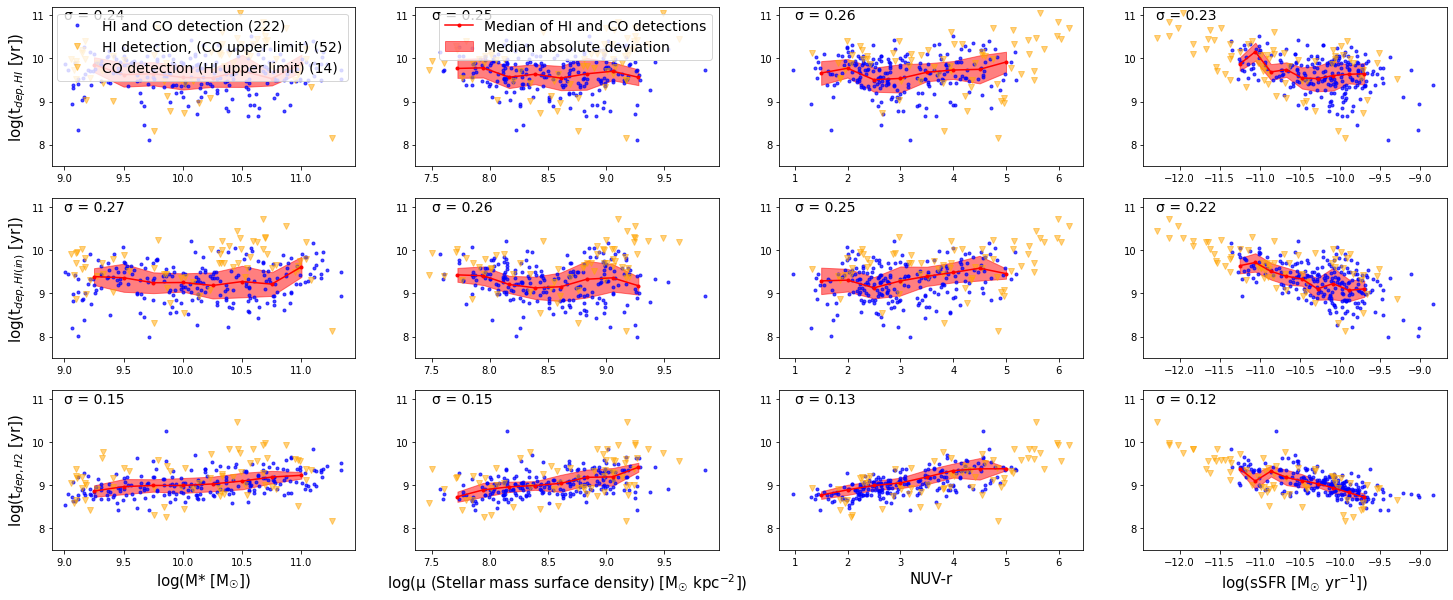

In [33]:
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker='.', linestyle='none', label='HI and CO detection (222)')
plt.plot(lgMSTAR_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker='v', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgMSTAR_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker='v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'red', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'r', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIgl_Mstar, fontsize=14)
plt.legend(loc='upper right', fontsize=14)

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'red', marker= '.', label='Median of HI and CO detections')
plt.fill_between(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], tdep_HIglpMAD_Must[1:-1], color= 'r', alpha = 0.5, label='Median absolute deviation')
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIgl_Must, fontsize=14)
plt.legend(loc='upper right', fontsize=14)

# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det1, lgtdep_HIgl_det1,'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'red', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], color= 'r', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatHIgl_NUVr, fontsize=14)

# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det1, lgtdep_HIgl_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIgl_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIgl_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'red', marker= '.')
plt.fill_between(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], color= 'r', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIgl_sSFR, fontsize=14)

# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylabel('log(t$_{dep, HI(in)}$ [yr])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'red', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'r', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIin_Mstar, fontsize=14)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'red', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], tdep_HIinpMAD_Must[1:-1], color= 'r', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIin_Must, fontsize=14)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'red', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], color= 'r', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatHIin_NUVr, fontsize=14)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det1, lgtdep_HIin_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_HIin_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_HIin_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'red', marker= '.')
plt.fill_between(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], color= 'r', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIin_sSFR, fontsize=14)

# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'red', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'r', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatH2_Mstar, fontsize=14)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.xlabel('log(μ (Stellar mass surface density) [M$_{☉}$ kpc$^{-2}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'red', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], tdep_H2pMAD_Must[1:-1], color= 'r', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatH2_Must, fontsize=14)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.xlabel('NUV-r', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'red', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], color= 'r', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatH2_NUVr, fontsize=14)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det1, lgtdep_H2_det1, 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det3, lgtdep_H2_det3, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4, lgtdep_H2_det4, 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.xlabel('log(sSFR [M$_{☉}$ yr$^{-1}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'red', marker= '.')
plt.fill_between(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], color= 'r', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatH2_sSFR, fontsize=14);

In [34]:
# Effect of restricting the HI gas mass to the optical region only, the average decrease in log(depletion time)
print(np.mean(lgtdep_HIgl_det1 - lgtdep_HIin_det1))

0.36735959248223743


7) Changing the depletion time plots to incude how the bulge-to-total ratio changes

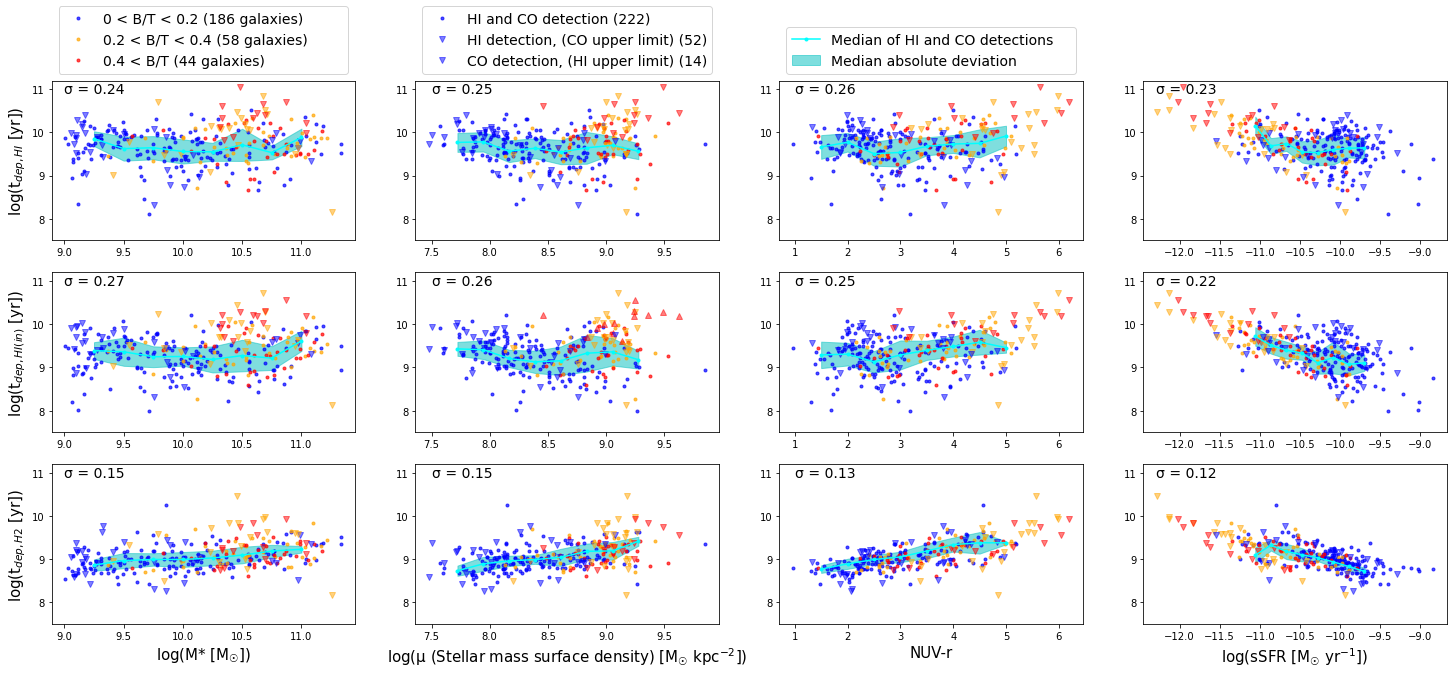

In [35]:
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker='.', linestyle='none', label= '0 < B/T < 0.2 (186 galaxies)')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker='.', linestyle='none', label= '0.2 < B/T < 0.4 (58 galaxies)')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker='.', linestyle='none', label= '0.4 < B/T (44 galaxies)')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker='v', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker='v', linestyle='none')

plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIgl_Mstar, fontsize=14)

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker = '.', linestyle='none', label='HI and CO detection (222)')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='CO detection, (HI upper limit) (14)')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], tdep_HIglpMAD_Must[1:-1], color= 'c', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIgl_Must, fontsize=14)

# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)],'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'cyan', marker= '.', label='Median of HI and CO detections')
plt.fill_between(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')
plt.text(1, 10.9, 'σ = %.2f' % ScatHIgl_NUVr, fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)

# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[1:-1], tdep_HIglmedian_sSFR[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_sSFR[1:-1], tdep_HIglnMAD_sSFR[1:-1], tdep_HIglpMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIgl_sSFR, fontsize=14)

# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylabel('log(t$_{dep, HI(in)}$ [yr])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIin_Mstar, fontsize=14)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], tdep_HIinpMAD_Must[1:-1], color= 'c', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatHIin_Must, fontsize=14)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], color= 'c', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatHIin_NUVr, fontsize=14)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[1:-1], tdep_HIinmedian_sSFR[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_sSFR[1:-1], tdep_HIinnMAD_sSFR[1:-1], tdep_HIinpMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIin_sSFR, fontsize=14)


# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatH2_Mstar, fontsize=14)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.plot(lgMuST_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMuST_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMuST_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMuST_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMuST_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgMuST_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMuST_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMuST_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(μ (Stellar mass surface density) [M$_{☉}$ kpc$^{-2}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], tdep_H2pMAD_Must[1:-1], color= 'c', alpha = 0.5)
plt.text(7.5, 10.9, 'σ = %.2f' % ScatH2_Must, fontsize=14)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.plot(NUVr_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(NUVr_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(NUVr_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(NUVr_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(NUVr_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(NUVr_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(NUVr_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(NUVr_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('NUV-r', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], color= 'c', alpha = 0.5)
plt.text(1, 10.9, 'σ = %.2f' % ScatH2_NUVr, fontsize=14)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(sSFR [M$_{☉}$ yr$^{-1}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[1:-1], tdep_H2median_sSFR[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_sSFR[1:-1], tdep_H2nMAD_sSFR[1:-1], tdep_H2pMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatH2_sSFR, fontsize=14);

In [36]:
# Finding the correlation of tdep and stellar properties
# For HI (global)
CorrHIgl_tdep_Mstar = np.corrcoef(lgMSTAR_det1, lgtdep_HIgl_det1)[0]
CorrHIgl_tdep_sSFR = np.corrcoef(lgsSFR_det1, lgtdep_HIgl_det1)[0]
# For HI (in)
CorrHIin_tdep_Mstar = np.corrcoef(lgMSTAR_det1, lgtdep_HIin_det1)[0]
CorrHIin_tdep_sSFR = np.corrcoef(lgsSFR_det1, lgtdep_HIin_det1)[0]
# For H2
CorrH2_tdep_Mstar = np.corrcoef(lgMSTAR_det1, lgtdep_H2_det1)[0]
CorrH2_tdep_sSFR = np.corrcoef(lgsSFR_det1, lgtdep_H2_det1)[0]

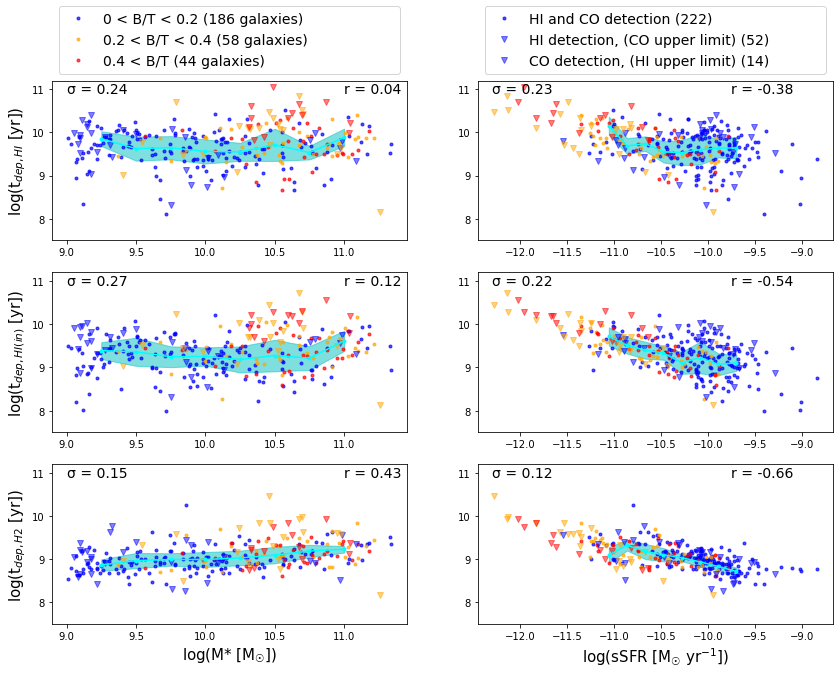

In [37]:
plt.figure(figsize=(14,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,2,1)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker='.', linestyle='none', label= '0 < B/T < 0.2 (186 galaxies)')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker='.', linestyle='none', label= '0.2 < B/T < 0.4 (58 galaxies)')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker='.', linestyle='none', label= '0.4 < B/T (44 galaxies)')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker='v', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker='v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker='v', linestyle='none')

plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIgl_Mstar, fontsize=14)
plt.text(11, 10.9, 'r = %.2f' % CorrHIgl_tdep_Mstar[1], fontsize=14)

# Depletion time of MHI(global) against sSFR
plt.subplot(3,2,2)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label='HI and CO detection (222)')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='CO detection, (HI upper limit) (14)')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker= 'v', linestyle='none')

plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[1:-1], tdep_HIglmedian_sSFR[1:-1], 'cyan', marker= '.')
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)
plt.fill_between(bins_sSFR[1:-1], tdep_HIglnMAD_sSFR[1:-1], tdep_HIglpMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIgl_sSFR, fontsize=14)
plt.text(-9.75, 10.9, 'r = %.2f' % CorrHIgl_tdep_sSFR[1], fontsize=14)

# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,2,3)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylabel('log(t$_{dep, HI(in)}$ [yr])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatHIin_Mstar, fontsize=14)
plt.text(11, 10.9, 'r = %.2f' % CorrHIin_tdep_Mstar[1], fontsize=14)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,2,4)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[1:-1], tdep_HIinmedian_sSFR[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_sSFR[1:-1], tdep_HIinnMAD_sSFR[1:-1], tdep_HIinpMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatHIin_sSFR, fontsize=14)
plt.text(-9.75, 10.9, 'r = %.2f' % CorrHIin_tdep_sSFR[1], fontsize=14)

# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,2,5)
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgMSTAR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgMSTAR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgMSTAR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgMSTAR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'c', alpha = 0.5)
plt.text(9, 10.9, 'σ = %.2f' % ScatH2_Mstar, fontsize=14)
plt.text(11, 10.9, 'r = %.2f' % CorrH2_tdep_Mstar[1], fontsize=14)

# Depletion time of MH2 against sSFR
plt.subplot(3,2,6)
plt.plot(lgsSFR_det1[np.where(B2TM_det1 < 0.2)], lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgsSFR_det1[np.where(B2TM_det1 > 0.4)], lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgsSFR_det3[np.where(B2TM_det3 < 0.2)], lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det3[np.where(B2TM_det3 > 0.4)], lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgsSFR_det4[np.where(B2TM_det4 < 0.2)], lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgsSFR_det4[np.where(B2TM_det4 > 0.4)], lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(sSFR [M$_{☉}$ yr$^{-1}$])', fontsize=15)
plt.ylim(7.5, 11.2)
plt.plot(bins_sSFR[1:-1], tdep_H2median_sSFR[1:-1], 'cyan', marker= '.')
plt.fill_between(bins_sSFR[1:-1], tdep_H2nMAD_sSFR[1:-1], tdep_H2pMAD_sSFR[1:-1], color= 'c', alpha = 0.5)
plt.text(-12.3, 10.9, 'σ = %.2f' % ScatH2_sSFR, fontsize=14)
plt.text(-9.75, 10.9, 'r = %.2f' % CorrH2_tdep_sSFR[1], fontsize=14);

8) Removing the points on the above graph and adding a shaded confidence region. Comparing the difference in medians of the total HI + CO detections between the sample of points that are disk dominated and the entire sample.

In [38]:
# Finding the MAD and median lines for the total galaxies is the 231 galaxies listed in the previous plot
# Finding the MAD and median lines for the disk-dominated galaxies only
# Stellar parameters
# Stellar mass
lgMSTAR_det1_d = lgMSTAR_det1[np.where(B2TM_det1 < 0.2)]
lgMSTAR_det3_d = lgMSTAR_det3[np.where(B2TM_det3 < 0.2)]
lgMSTAR_det4_d = lgMSTAR_det4[np.where(B2TM_det4 < 0.2)]
# Stellar surface density
lgMuST_det1_d = lgMuST_det1[np.where(B2TM_det1 < 0.2)]
lgMuST_det3_d = lgMuST_det3[np.where(B2TM_det3 < 0.2)]
lgMuST_det4_d = lgMuST_det4[np.where(B2TM_det4 < 0.2)]
# NUV-r
NUVr_det1_d = NUVr_det1[np.where(B2TM_det1 < 0.2)]
NUVr_det3_d = NUVr_det3[np.where(B2TM_det3 < 0.2)]
NUVr_det4_d = NUVr_det4[np.where(B2TM_det4 < 0.2)]
# sSFR
lgsSFR_det1_d = lgsSFR_det1[np.where(B2TM_det1 < 0.2)]
lgsSFR_det3_d = lgsSFR_det3[np.where(B2TM_det3 < 0.2)]
lgsSFR_det4_d = lgsSFR_det4[np.where(B2TM_det4 < 0.2)]

# Selecting the galaxies (detections only) that are disk dominated
# HI (global)
lgtdep_HIgl_det_d = lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)]
# HI (inner)
lgtdep_HIin_det_d = lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)]
# H2
lgtdep_H2_det_d = lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)]

In [39]:
# Arrays for the bins
bins_Mstar_d = np.linspace(9, 11.25, 10)
bins_NUVr_d = np.linspace(1, 5.5, 10)
bins_sSFR_d = np.linspace(-11.25, -9.5, 10)
bins_Must_d = np.linspace(7.5, 9.5, 10)

# Array of zeroes to store the median of each bin
# Depletion times for HI (global)
tdep_HIglmedian_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_HIglMAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_HIglmedian_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_HIglMAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_HIglmedian_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_HIglMAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_HIglmedian_Must_d = np.zeros(len(bins_Must_d))
tdep_HIglMAD_Must_d = np.zeros(len(bins_Must_d))

# Depletion times for HI (optical)
tdep_HIinmedian_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_HIinMAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_HIinmedian_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_HIinMAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_HIinmedian_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_HIinMAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_HIinmedian_Must_d = np.zeros(len(bins_Must_d))
tdep_HIinMAD_Must_d = np.zeros(len(bins_Must_d))

# Depletion time for H2
tdep_H2median_Mstar_d = np.zeros(len(bins_Mstar_d))
tdep_H2MAD_Mstar_d = np.zeros(len(bins_Mstar_d))

tdep_H2median_NUVr_d = np.zeros(len(bins_NUVr_d))
tdep_H2MAD_NUVr_d = np.zeros(len(bins_NUVr_d))

tdep_H2median_sSFR_d = np.zeros(len(bins_sSFR_d))
tdep_H2MAD_sSFR_d = np.zeros(len(bins_sSFR_d))

tdep_H2median_Must_d = np.zeros(len(bins_Must_d))
tdep_H2MAD_Must_d = np.zeros(len(bins_Must_d))

In [40]:
# Using a for loop to iterate over the median values for each of the bins
for i in range(len(bins_Mstar_d) -1):
  # Depletion time of HI (global) (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_HIglmedian_Mstar_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_HIglMAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIglmedian_NUVr_d[i] = np.median(lgtdep_HIgl_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_HIglMAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIglmedian_sSFR_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_HIglMAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])

  # Median and MAD for the Must graph
  tdep_HIglmedian_Must_d[i] = np.median(lgtdep_HIgl_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_HIglMAD_Must_d[i] = stats.median_abs_deviation(lgtdep_HIgl_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])

  # Depletion time of HI (optical) (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_HIinmedian_Mstar_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_HIinMAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_HIinmedian_NUVr_d[i] = np.median(lgtdep_HIin_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_HIinMAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_HIinmedian_sSFR_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_HIinMAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_HIinmedian_Must_d[i] = np.median(lgtdep_HIin_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_HIinMAD_Must_d[i] = stats.median_abs_deviation(lgtdep_HIin_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  
  # Depletion time of H2 (disk dominated, detections)
  # Median and MAD for the Mstar graph
  tdep_H2median_Mstar_d[i] = np.median(lgtdep_H2_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])
  tdep_H2MAD_Mstar_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgMSTAR_det1_d >= bins_Mstar_d[i]) & (lgMSTAR_det1_d <= bins_Mstar_d[i+1]))])

  # Median and MAD for the NUV-r graph
  tdep_H2median_NUVr_d[i] = np.median(lgtdep_H2_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])
  tdep_H2MAD_NUVr_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((NUVr_det1_d >= bins_NUVr_d[i]) & (NUVr_det1_d <= bins_NUVr_d[i+1]))])

  # Median and MAD for the sSFR graph
  tdep_H2median_sSFR_d[i] = np.median(lgtdep_H2_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  tdep_H2MAD_sSFR_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgsSFR_det1_d >= bins_sSFR_d[i]) & (lgsSFR_det1_d <= bins_sSFR_d[i+1]))])
  
  #Median and MAD for the Must graph
  tdep_H2median_Must_d[i] = np.median(lgtdep_H2_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])
  tdep_H2MAD_Must_d[i] = stats.median_abs_deviation(lgtdep_H2_det_d[np.where((lgMuST_det1_d >= bins_Must_d[i]) & (lgMuST_det1_d <= bins_Must_d[i+1]))])

In [41]:
# Working out the upper and lower bounds of the median absolute deviation
# HI (global)
# Mstar graph median bounds
tdep_HIglpMAD_Mstar_d = tdep_HIglmedian_Mstar_d + tdep_HIglMAD_Mstar_d
tdep_HIglnMAD_Mstar_d = tdep_HIglmedian_Mstar_d - tdep_HIglMAD_Mstar_d
# NUV-r graph median bounds
tdep_HIglpMAD_NUVr_d = tdep_HIglmedian_NUVr_d + tdep_HIglMAD_NUVr_d
tdep_HIglnMAD_NUVr_d = tdep_HIglmedian_NUVr_d - tdep_HIglMAD_NUVr_d
# sSFR graph median bounds
tdep_HIglpMAD_sSFR_d = tdep_HIglmedian_sSFR_d + tdep_HIglMAD_sSFR_d
tdep_HIglnMAD_sSFR_d = tdep_HIglmedian_sSFR_d - tdep_HIglMAD_sSFR_d
# Must graph median bounds
tdep_HIglpMAD_Must_d = tdep_HIglmedian_Must_d + tdep_HIglMAD_Must_d
tdep_HIglnMAD_Must_d = tdep_HIglmedian_Must_d - tdep_HIglMAD_Must_d

# HI (optical)
# Mstar graph median bounds
tdep_HIinpMAD_Mstar_d = tdep_HIinmedian_Mstar_d + tdep_HIinMAD_Mstar_d
tdep_HIinnMAD_Mstar_d = tdep_HIinmedian_Mstar_d - tdep_HIinMAD_Mstar_d
# NUV-r graph median bounds
tdep_HIinpMAD_NUVr_d = tdep_HIinmedian_NUVr_d + tdep_HIinMAD_NUVr_d
tdep_HIinnMAD_NUVr_d = tdep_HIinmedian_NUVr_d - tdep_HIinMAD_NUVr_d
# sSFR graph median bounds
tdep_HIinpMAD_sSFR_d = tdep_HIinmedian_sSFR_d + tdep_HIinMAD_sSFR_d
tdep_HIinnMAD_sSFR_d = tdep_HIinmedian_sSFR_d - tdep_HIinMAD_sSFR_d
# Must graph median bounds
tdep_HIinpMAD_Must_d = tdep_HIinmedian_Must_d + tdep_HIinMAD_Must_d
tdep_HIinnMAD_Must_d = tdep_HIinmedian_Must_d - tdep_HIinMAD_Must_d

# H2
# Mstar graph median bounds
tdep_H2pMAD_Mstar_d = tdep_H2median_Mstar_d + tdep_H2MAD_Mstar_d
tdep_H2nMAD_Mstar_d = tdep_H2median_Mstar_d - tdep_H2MAD_Mstar_d
# NUV-r graph median bounds
tdep_H2pMAD_NUVr_d = tdep_H2median_NUVr_d + tdep_H2MAD_NUVr_d
tdep_H2nMAD_NUVr_d = tdep_H2median_NUVr_d - tdep_H2MAD_NUVr_d
# sSFR graph median bounds
tdep_H2pMAD_sSFR_d = tdep_H2median_sSFR_d + tdep_H2MAD_sSFR_d
tdep_H2nMAD_sSFR_d = tdep_H2median_sSFR_d - tdep_H2MAD_sSFR_d
# Must graph median bounds
tdep_H2pMAD_Must_d = tdep_H2median_Must_d + tdep_H2MAD_Must_d
tdep_H2nMAD_Must_d = tdep_H2median_Must_d - tdep_H2MAD_Must_d

In [42]:
# Finding the scatter present between the median lines and MAD for each plot
# Depletion time of HI (global)
ScatHIgl_Mstar_d = np.mean(tdep_HIglMAD_Mstar_d[1:-1])
ScatHIgl_NUVr_d = np.mean(tdep_HIglMAD_NUVr_d[1:-1])
ScatHIgl_sSFR_d = np.mean(tdep_HIglMAD_sSFR_d[:-1])
ScatHIgl_Must_d = np.mean(tdep_HIglMAD_Must_d[1:-1])
# Depletion time of HI (optical)
ScatHIin_Mstar_d = np.mean(tdep_HIinMAD_Mstar_d[1:-1])
ScatHIin_NUVr_d = np.mean(tdep_HIinMAD_NUVr_d[1:-1])
ScatHIin_sSFR_d = np.mean(tdep_HIinMAD_sSFR_d[:-1])
ScatHIin_Must_d = np.mean(tdep_HIinMAD_Must_d[1:-1])
# Depletion time of H2
ScatH2_Mstar_d = np.mean(tdep_H2MAD_Mstar_d[1:-1])
ScatH2_NUVr_d = np.mean(tdep_H2MAD_NUVr_d[1:-1])
ScatH2_sSFR_d = np.mean(tdep_H2MAD_sSFR_d[:-1])
ScatH2_Must_d = np.mean(tdep_H2MAD_Must_d[1:-1])

In [43]:
# Finding the average of the median lines:
# The 'blue' refers to the median of the spirals
# The 'red' refers to the total median the sample, the number is the 'position' of the subplot below
# All the disk dominated galaxies:
blue341 = np.mean(tdep_HIglmedian_Mstar_d)
blue342 = np.mean(tdep_HIglmedian_Must_d)
blue343 = np.mean(tdep_HIglmedian_NUVr_d)
blue344 = np.mean(tdep_HIglmedian_sSFR_d)

blue345 = np.mean(tdep_HIinmedian_Mstar_d)
blue346 = np.mean(tdep_HIinmedian_Must_d)
blue347 = np.mean(tdep_HIinmedian_NUVr_d)
blue348 = np.mean(tdep_HIinmedian_sSFR_d)

blue349 = np.mean(tdep_H2median_Mstar_d)
blue3410 = np.mean(tdep_H2median_Must_d)
blue3411 = np.mean(tdep_H2median_NUVr_d)
blue3412 = np.mean(tdep_H2median_sSFR_d)

blueMstar = np.array([blue341, blue345, blue349])
blueMust = np.array([blue342, blue346, blue3410])
blueNUVr = np.array([blue343, blue347, blue3411])
bluesSFR = np.array([blue344, blue348, blue3412])

# All the galaxies in the sample
red341 = np.mean(tdep_HIglmedian_Mstar)
red342 = np.mean(tdep_HIglmedian_Must)
red343 = np.mean(tdep_HIglmedian_NUVr)
red344 = np.mean(tdep_HIglmedian_sSFR)

red345 = np.mean(tdep_HIinmedian_Mstar)
red346 = np.mean(tdep_HIinmedian_Must)
red347 = np.mean(tdep_HIinmedian_NUVr)
red348 = np.mean(tdep_HIinmedian_sSFR)

red349 = np.mean(tdep_H2median_Mstar)
red3410 = np.mean(tdep_H2median_Must)
red3411 = np.mean(tdep_H2median_NUVr)
red3412 = np.mean(tdep_H2median_sSFR)

redMstar = np.array([red341, red345, red349])
redMust = np.array([red342, red346, red3410])
redNUVr = np.array([red343, red347, red3411])
redsSFR = np.array([red344, red348, red3412])

In [44]:
print(blueMstar, blueMust, blueNUVr, bluesSFR)
print(redMstar, redMust, redNUVr, redsSFR)

[8.70194135 8.32644091 8.0980135 ] [8.65729522 8.25986994 8.11594362] [8.6982234  8.3753674  8.16965275] [8.76814218 8.44460318 8.15579243]
[8.6947186  8.36589724 8.11721621] [8.69181023 8.36476678 8.1222332 ] [8.73163875 8.40781447 8.17637148] [8.74003606 8.41136691 8.16269503]


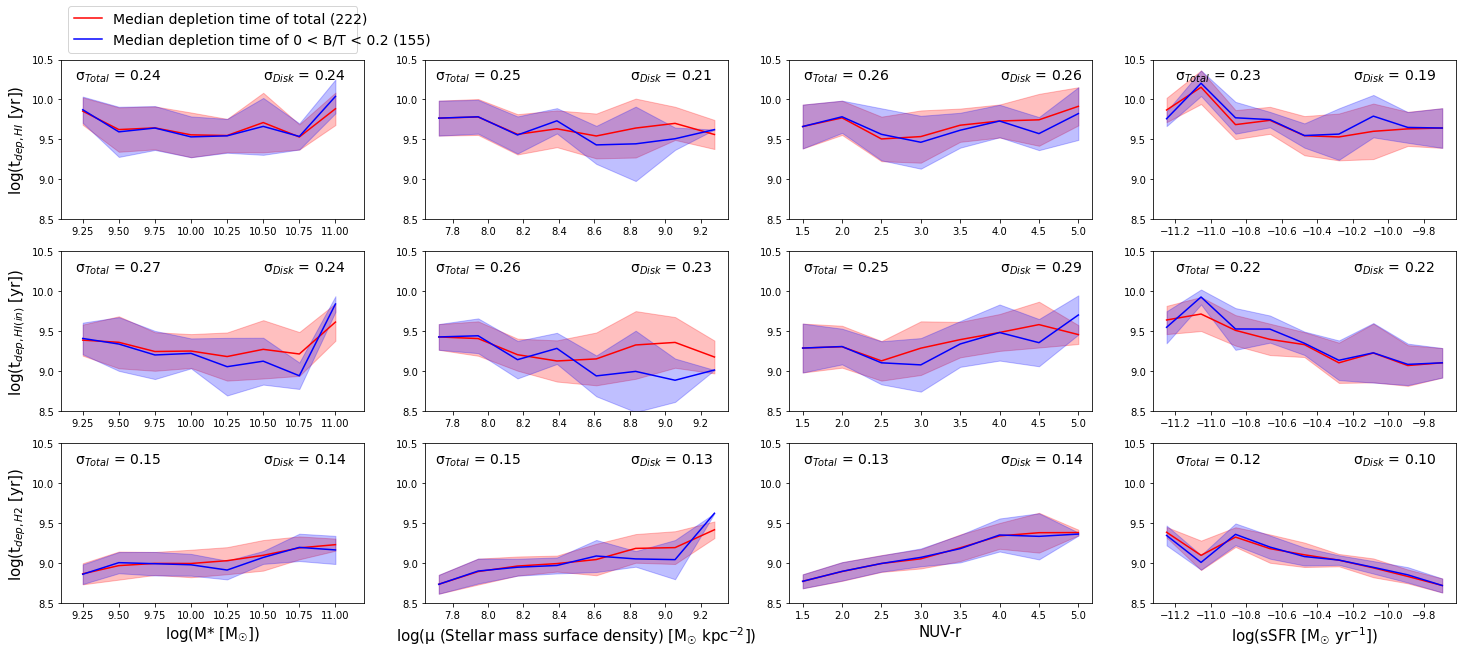

In [45]:
# Plotting the median lines for disk dominated vs the whole sample across four stellar properties
plt.figure(figsize=(25,10))
# Plotting the depletion time for HI(global) mass against stellar properties
# MHI(global) against stellar mass
plt.subplot(3,4,1)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.plot(bins_Mstar[1:-1], tdep_HIglmedian_Mstar[1:-1], 'red', label='Median depletion time of total (222)')
plt.fill_between(bins_Mstar[1:-1], tdep_HIglnMAD_Mstar[1:-1], tdep_HIglpMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_HIglmedian_Mstar_d[1:-1], 'blue', label='Median depletion time of 0 < B/T < 0.2 (155)')
plt.fill_between(bins_Mstar_d[1:-1], tdep_HIglnMAD_Mstar_d[1:-1], tdep_HIglpMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_Mstar, fontsize=14)
plt.text(10.5, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_Mstar_d, fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)

# Depletion time of MHI(global) against stellar surface density
plt.subplot(3,4,2)
plt.ylim(8.5, 10.5)
plt.plot(bins_Must[1:-1], tdep_HIglmedian_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_HIglnMAD_Must[1:-1], tdep_HIglpMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_HIglmedian_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_HIglnMAD_Must_d[1:-1], tdep_HIglpMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_Must, fontsize=14)
plt.text(8.8, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_Must_d, fontsize=14)

# Depletion time of MHI(global) against NUV-r
plt.subplot(3,4,3)
plt.ylim(8.5, 10.5)
plt.plot(bins_NUVr[1:-1], tdep_HIglmedian_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_HIglnMAD_NUVr[1:-1], tdep_HIglpMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_HIglmedian_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_HIglnMAD_NUVr_d[1:-1], tdep_HIglpMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_NUVr, fontsize=14)
plt.text(4, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_NUVr_d, fontsize=14)

# Depletion time of MHI(global) against sSFR
plt.subplot(3,4,4)
plt.ylim(8.5, 10.5)
plt.plot(bins_sSFR[:-1], tdep_HIglmedian_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_HIglnMAD_sSFR[:-1], tdep_HIglpMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_HIglmedian_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_HIglnMAD_sSFR_d[:-1], tdep_HIglpMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIgl_sSFR, fontsize=14)
plt.text(-10.2, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIgl_sSFR_d, fontsize=14)


# Plotting the depletion time for HI(in) mass against stellar properties
# Depletion time of MHI(in) against stellar mass
plt.subplot(3,4,5)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.ylabel('log(t$_{dep, HI(in)}$ [yr])', fontsize=15)
plt.plot(bins_Mstar[1:-1], tdep_HIinmedian_Mstar[1:-1], 'red')
plt.fill_between(bins_Mstar[1:-1], tdep_HIinnMAD_Mstar[1:-1], tdep_HIinpMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_HIinmedian_Mstar_d[1:-1], 'blue')
plt.fill_between(bins_Mstar_d[1:-1], tdep_HIinnMAD_Mstar_d[1:-1], tdep_HIinpMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_Mstar, fontsize=14)
plt.text(10.5, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_Mstar_d, fontsize=14)

# Depletion time of MHI(in) against stellar surface density
plt.subplot(3,4,6)
plt.ylim(8.5, 10.5)
plt.plot(bins_Must[1:-1], tdep_HIinmedian_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_HIinnMAD_Must[1:-1], tdep_HIinpMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_HIinmedian_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_HIinnMAD_Must_d[1:-1], tdep_HIinpMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_Must, fontsize=14)
plt.text(8.8, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_Must_d, fontsize=14)

# Depletion time of MHI(in) against NUV-r
plt.subplot(3,4,7)
plt.ylim(8.5, 10.5)
plt.plot(bins_NUVr[1:-1], tdep_HIinmedian_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_HIinnMAD_NUVr[1:-1], tdep_HIinpMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_HIinmedian_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_HIinnMAD_NUVr_d[1:-1], tdep_HIinpMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_NUVr, fontsize=14)
plt.text(4, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_NUVr_d, fontsize=14)

# Depletion time of MHI(in) against sSFR
plt.subplot(3,4,8)
plt.ylim(8.5, 10.5)
plt.plot(bins_sSFR[:-1], tdep_HIinmedian_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_HIinnMAD_sSFR[:-1], tdep_HIinpMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_HIinmedian_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_HIinnMAD_sSFR_d[:-1], tdep_HIinpMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatHIin_sSFR, fontsize=14)
plt.text(-10.2, 10.25, 'σ$_{Disk}$ = %.2f' % ScatHIin_sSFR_d, fontsize=14)


# Plotting the depletion time of H2 mass against stellar properties
# Depletion time of MH2 against stellar mass
plt.subplot(3,4,9)
plt.ylim(8.5, 10.5)
plt.xlim(9.1, 11.2)
plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.plot(bins_Mstar[1:-1], tdep_H2median_Mstar[1:-1], 'red')
plt.fill_between(bins_Mstar[1:-1], tdep_H2nMAD_Mstar[1:-1], tdep_H2pMAD_Mstar[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Mstar_d[1:-1], tdep_H2median_Mstar_d[1:-1], 'blue')
plt.fill_between(bins_Mstar_d[1:-1], tdep_H2nMAD_Mstar_d[1:-1], tdep_H2pMAD_Mstar_d[1:-1], color= 'b', alpha = 0.25)
plt.text(9.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_Mstar, fontsize=14)
plt.text(10.5, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_Mstar_d, fontsize=14)

# Depletion time of MH2 against stellar surface density
plt.subplot(3,4,10)
plt.ylim(8.5, 10.5)
plt.xlabel('log(μ (Stellar mass surface density) [M$_{☉}$ kpc$^{-2}$])', fontsize=15)
plt.plot(bins_Must[1:-1], tdep_H2median_Must[1:-1], 'red')
plt.fill_between(bins_Must[1:-1], tdep_H2nMAD_Must[1:-1], tdep_H2pMAD_Must[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_Must_d[1:-1], tdep_H2median_Must_d[1:-1], 'blue')
plt.fill_between(bins_Must_d[1:-1], tdep_H2nMAD_Must_d[1:-1], tdep_H2pMAD_Must_d[1:-1], color= 'b', alpha = 0.25)
plt.text(7.7, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_Must, fontsize=14)
plt.text(8.8, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_Must_d, fontsize=14)

# Depletion time of MH2 against NUVr
plt.subplot(3,4,11)
plt.ylim(8.5, 10.5)
plt.xlabel('NUV-r', fontsize=15)
plt.plot(bins_NUVr[1:-1], tdep_H2median_NUVr[1:-1], 'red')
plt.fill_between(bins_NUVr[1:-1], tdep_H2nMAD_NUVr[1:-1], tdep_H2pMAD_NUVr[1:-1], color= 'r', alpha = 0.25)
plt.plot(bins_NUVr_d[1:-1], tdep_H2median_NUVr_d[1:-1], 'blue')
plt.fill_between(bins_NUVr_d[1:-1], tdep_H2nMAD_NUVr_d[1:-1], tdep_H2pMAD_NUVr_d[1:-1], color= 'b', alpha = 0.25)
plt.text(1.5, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_NUVr, fontsize=14)
plt.text(4, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_NUVr_d, fontsize=14)

# Depletion time of MH2 against sSFR
plt.subplot(3,4,12)
plt.ylim(8.5, 10.5)
plt.xlabel('log(sSFR [M$_{☉}$ yr$^{-1}$])', fontsize=15)
plt.plot(bins_sSFR[:-1], tdep_H2median_sSFR[:-1], 'red')
plt.fill_between(bins_sSFR[:-1], tdep_H2nMAD_sSFR[:-1], tdep_H2pMAD_sSFR[:-1], color= 'r', alpha = 0.25)
plt.plot(bins_sSFR_d[:-1], tdep_H2median_sSFR_d[:-1], 'blue')
plt.fill_between(bins_sSFR_d[:-1], tdep_H2nMAD_sSFR_d[:-1], tdep_H2pMAD_sSFR_d[:-1], color= 'b', alpha = 0.25)
plt.text(-11.2, 10.25, 'σ$_{Total}$ = %.2f' % ScatH2_sSFR, fontsize=14)
plt.text(-10.2, 10.25, 'σ$_{Disk}$ = %.2f' % ScatH2_sSFR_d, fontsize=14);

9) Comparing the depletion times more directly, looking at the direct correspondance of the H2 to HI (global) and the H2 to HI (optical)

In [46]:
a1 = len(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)])
b1 = len(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)])
c1 = len(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)])
d1 = a1+b1+c1
print('Disk dominated galaxies: %.1f' % d1)
a2 = len(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))])
b2 = len(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))])
c2 = len(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))])
d2 = a2+b2+c2
print('Disk + bulge galaxies: %.1f' % d2)
a3 = len(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)])
b3 = len(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)])
c3 = len(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)])
d3 = a3+b3+c3
print('Prominent bulge galaxies: %.1f' % d3)

Disk dominated galaxies: 186.0
Disk + bulge galaxies: 58.0
Prominent bulge galaxies: 44.0


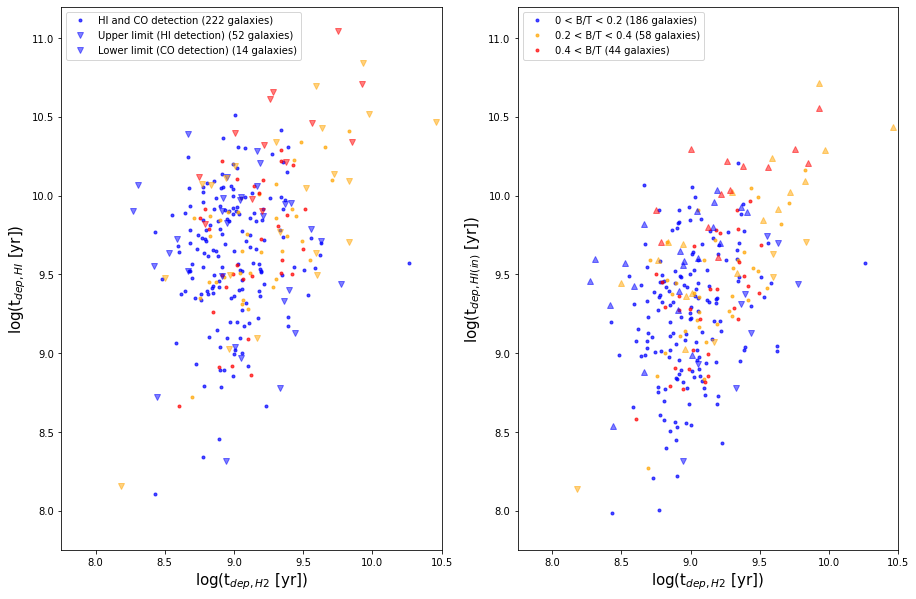

In [47]:
plt.figure(figsize=(15,10))
# Comparing H2 and HI (global)
plt.subplot(1,2,1)
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIgl_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label='HI and CO detection (222 galaxies)')
plt.plot(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIgl_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none')
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIgl_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none')

plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIgl_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='Upper limit (HI detection) (52 galaxies)')
plt.plot(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIgl_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIgl_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIgl_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none', label='Lower limit (CO detection) (14 galaxies)')
plt.plot(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIgl_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIgl_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='upper left')

# Comparing H2 and HI (optical)
plt.subplot(1,2,2)
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 < 0.2)], lgtdep_HIin_det1[np.where(B2TM_det1 < 0.2)], 'blue', alpha = 0.7, marker= '.', linestyle='none', label= '0 < B/T < 0.2 (186 galaxies)')
plt.plot(lgtdep_H2_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], lgtdep_HIin_det1[np.where((B2TM_det1 > 0.2) & (B2TM_det1 < 0.4))], 'orange', alpha = 0.7, marker = '.', linestyle='none', label= '0.2 < B/T < 0.4 (58 galaxies)')
plt.plot(lgtdep_H2_det1[np.where(B2TM_det1 > 0.4)], lgtdep_HIin_det1[np.where(B2TM_det1 > 0.4)], 'red', alpha = 0.7, marker = '.', linestyle='none', label= '0.4 < B/T (44 galaxies)')

plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 < 0.2)], lgtdep_HIin_det3[np.where(B2TM_det3 < 0.2)], 'blue', alpha = 0.5, marker= '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], lgtdep_HIin_det3[np.where((B2TM_det3 > 0.2) & (B2TM_det3 < 0.4))], 'orange', alpha = 0.5, marker = '^', linestyle='none')
plt.plot(lgtdep_H2_det3[np.where(B2TM_det3 > 0.4)], lgtdep_HIin_det3[np.where(B2TM_det3 > 0.4)], 'red', alpha = 0.5, marker = '^', linestyle='none')

plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 < 0.2)], lgtdep_HIin_det4[np.where(B2TM_det4 < 0.2)], 'blue', alpha = 0.5, marker= 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], lgtdep_HIin_det4[np.where((B2TM_det4 > 0.2) & (B2TM_det4 < 0.4))], 'orange', alpha = 0.5, marker = 'v', linestyle='none')
plt.plot(lgtdep_H2_det4[np.where(B2TM_det4 > 0.4)], lgtdep_HIin_det4[np.where(B2TM_det4 > 0.4)], 'red', alpha = 0.5, marker = 'v', linestyle='none')

plt.xlabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.xlim(7.75, 10.5)
plt.ylim(7.75, 11.2)
plt.legend(loc='upper left');

10) Investigating the depletion times of the HI global, optical and H2 when compared to how offset each galaxy is from the star forming main sequence

In [48]:
# Using the specific star forming main sequence (sSFMS) from the xGASS paper (2018)

MSTAR_det1 = 10**lgMSTAR_det1
MSTAR_det3 = 10**lgMSTAR_det3
MSTAR_det4 = 10**lgMSTAR_det4

def sSFMSfit(Mstar):
  return -0.344*(np.log10(Mstar) -9) - 9.822

lgsSFMS_det1 = sSFMSfit(MSTAR_det1)
lgsSFMS_det3 = sSFMSfit(MSTAR_det3)
lgsSFMS_det4 = sSFMSfit(MSTAR_det4)

# Making an upper and lower bounds of this best fit function
def sigma_sSFMS(Mstar):
  return 0.088*(np.log10(Mstar) -9) + 0.188
uplgsSFMS_det1 = lgsSFMS_det1 + sigma_sSFMS(MSTAR_det1)
dwlgsSFMS_det1 = lgsSFMS_det1 - sigma_sSFMS(MSTAR_det1)

In [49]:
# Finding the main sequence offset: lgSFR_det(1,2,3) - lgSFMS_det(1,2,3) = lgSFMS_off_det(1,2,3)

def sSFMS_off(lgsSFR, lgsSFMS):
  return lgsSFR - lgsSFMS

lgsSFMS_off_det1 = sSFMS_off(lgsSFR_det1, lgsSFMS_det1)
lgsSFMS_off_det3 = sSFMS_off(lgsSFR_det3, lgsSFMS_det3)
lgsSFMS_off_det4 = sSFMS_off(lgsSFR_det4, lgsSFMS_det4)
lgsSFMS_off_dw = sSFMS_off(lgsSFR_det1, dwlgsSFMS_det1)
lgsSFMS_off_up = sSFMS_off(lgsSFR_det1, uplgsSFMS_det1)

In [50]:
# Fitting a line to the SFMS
x = lgMSTAR_det1
p = np.linspace(min(lgMSTAR_det1), max(lgMSTAR_det1), 100)
y1 = lgsSFMS_det1
def linfun(x, m, c): 
    return m*x + c
popt1, pcov1 = curve_fit(linfun, x, y1)
# Fitting a line to the SFMS upper limit
y2 = uplgsSFMS_det1
def linfun(x, m, c): 
    return m*x + c
popt2, pcov2 = curve_fit(linfun, x, y2)
# Fitting a line to the SFMS lower limit
y3 = dwlgsSFMS_det1
def linfun(x, m, c): 
    return m*x + c
popt3, pcov3 = curve_fit(linfun, x, y3)

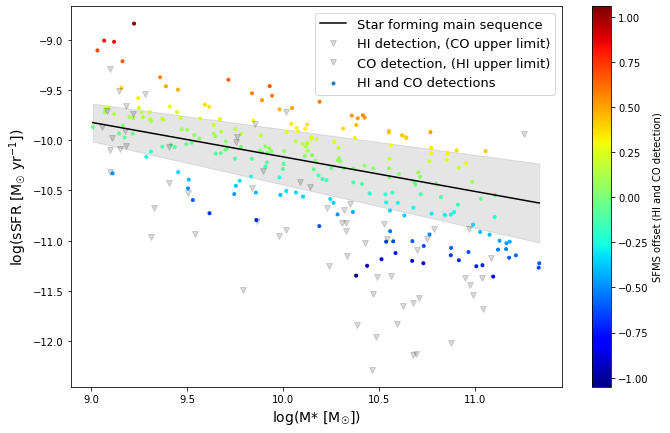

In [51]:
# Plotting a scatter plot with colourbar to reflect the offset of the data from the SFMS
plt.figure(figsize=(11,7))
plt.plot(p, linfun(p, *popt1), 'k-', label='Star forming main sequence')
plt.fill_between(p, linfun(p, *popt3), linfun(p, *popt2), color='grey', alpha = 0.2)
plt.scatter(lgMSTAR_det1, lgsSFR_det1, c=lgsSFMS_off_det1, cmap='jet', marker= '.', label='HI and CO detections')
plt.colorbar(label='SFMS offset (HI and CO detection)', orientation='vertical')
plt.plot(lgMSTAR_det3, lgsSFR_det3, 'black', marker='v', linestyle='none', alpha=0.15, label='HI detection, (CO upper limit)')
plt.plot(lgMSTAR_det4, lgsSFR_det4, 'black', marker='v', linestyle='none', alpha=0.15, label='CO detection, (HI upper limit)')
plt.legend(loc='upper right', fontsize=13)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=14)
plt.ylabel('log(sSFR [M$_{☉}$ yr$^{-1}$])', fontsize=14);

11) Using the offset from the specific star forming main sequence with the depletion times to investigate the larger scatter seen by the HI when restricted to the optical region

In [52]:
# Finding the running median of the galaxies for H2
# Arrays for the bins
SFMSbins = np.linspace(-0.75, 0.75, 7)

# Array of zeroes to store the median of each bin
SFMS_HIgl_median = np.zeros(len(SFMSbins))
SFMS_HIgl_MAD = np.zeros(len(SFMSbins))

SFMS_HIin_median = np.zeros(len(SFMSbins))
SFMS_HIin_MAD = np.zeros(len(SFMSbins))

SFMS_H2_median = np.zeros(len(SFMSbins))
SFMS_H2_MAD = np.zeros(len(SFMSbins))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(SFMSbins) -1):
  # Median and MAD for the SFMS of t(dep) for MHI (global)
  SFMS_HIgl_median[i] = np.median(lgtdep_HIgl_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])
  SFMS_HIgl_MAD[i] = stats.median_abs_deviation(lgtdep_HIgl_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])

  # Median and MAD for the SFMS of t(dep) for MHI (optical)
  SFMS_HIin_median[i] = np.median(lgtdep_HIin_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])
  SFMS_HIin_MAD[i] = stats.median_abs_deviation(lgtdep_HIin_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])

  # Median and MAD for the SFMS of t(dep) for MH2
  SFMS_H2_median[i] = np.median(lgtdep_H2_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])
  SFMS_H2_MAD[i] = stats.median_abs_deviation(lgtdep_H2_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
SFMS_HIgl_pMAD = SFMS_HIgl_median + SFMS_HIgl_MAD
SFMS_HIgl_nMAD = SFMS_HIgl_median - SFMS_HIgl_MAD

SFMS_HIin_pMAD = SFMS_HIin_median + SFMS_HIin_MAD
SFMS_HIin_nMAD = SFMS_HIin_median - SFMS_HIin_MAD

SFMS_H2_pMAD = SFMS_H2_median + SFMS_H2_MAD
SFMS_H2_nMAD = SFMS_H2_median - SFMS_H2_MAD

In [53]:
# Finding the scatter present between the median lines and MAD for each plot
# For HI (global)
ScatHIgl_SFMS = np.mean(SFMS_HIgl_MAD[:-1])
# For HI (optical)
ScatHIin_SFMS = np.mean(SFMS_HIin_MAD[:-1])
# For H2
ScatH2_SFMS = np.mean(SFMS_H2_MAD[:-1])

# Finding the correlation present in each plot
# For HI (global)
CorrHIgl_SFMS = np.corrcoef(lgsSFMS_off_det1, lgtdep_HIgl_det1)[0]
# For HI (in)
CorrHIin_SFMS = np.corrcoef(lgsSFMS_off_det1, lgtdep_HIin_det1)[0]
# For H2
CorrH2_SFMS = np.corrcoef(lgsSFMS_off_det1, lgtdep_H2_det1)[0]

In [54]:
# Finding the scatter of all points inside the bounds of the SFMS
# Finding the points of all the variables in the SFMS
lgsSFMS_off_det1_in = lgsSFMS_off_det1[np.where((lgsSFMS_off_det1 > np.mean(lgsSFMS_off_up)) & (lgsSFMS_off_det1 < np.mean(lgsSFMS_off_dw)))]
lgtdep_HIgl_det1_in = lgtdep_HIgl_det1[np.where((lgsSFMS_off_det1 > np.mean(lgsSFMS_off_up)) & (lgsSFMS_off_det1 < np.mean(lgsSFMS_off_dw)))]
lgtdep_HIin_det1_in = lgtdep_HIin_det1[np.where((lgsSFMS_off_det1 > np.mean(lgsSFMS_off_up)) & (lgsSFMS_off_det1 < np.mean(lgsSFMS_off_dw)))]
lgtdep_H2_det1_in = lgtdep_H2_det1[np.where((lgsSFMS_off_det1 > np.mean(lgsSFMS_off_up)) & (lgsSFMS_off_det1 < np.mean(lgsSFMS_off_dw)))]

# Finding a new MAD for these, to find a new scatter
# Arrays for the bins
inSFMSbins = np.linspace(np.mean(lgsSFMS_off_up), np.mean(lgsSFMS_off_dw), 4)

# Array of zeroes to store the median of each bin
inSFMS_HIgl_MAD = np.zeros(len(inSFMSbins))
inSFMS_HIin_MAD = np.zeros(len(inSFMSbins))
inSFMS_H2_MAD = np.zeros(len(inSFMSbins))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(inSFMSbins) -1):
  # Median and MAD for the SFMS of t(dep) for MHI (global)
  inSFMS_HIgl_MAD[i] = stats.median_abs_deviation(lgtdep_HIgl_det1_in[np.where((lgsSFMS_off_det1_in >= inSFMSbins[i]) & (lgsSFMS_off_det1_in <= inSFMSbins[i+1]))])

  # Median and MAD for the SFMS of t(dep) for MHI (optical)
  inSFMS_HIin_MAD[i] = stats.median_abs_deviation(lgtdep_HIin_det1_in[np.where((lgsSFMS_off_det1_in >= inSFMSbins[i]) & (lgsSFMS_off_det1_in <= inSFMSbins[i+1]))])

  # Median and MAD for the SFMS of t(dep) for MH2
  inSFMS_H2_MAD[i] = stats.median_abs_deviation(lgtdep_H2_det1_in[np.where((lgsSFMS_off_det1_in >= inSFMSbins[i]) & (lgsSFMS_off_det1_in <= inSFMSbins[i+1]))])

# Finding the scatter present between the median lines and MAD for each plot
# For HI (global)
ScatHIgl_inSFMS = np.mean(inSFMS_HIgl_MAD[:-1])
# For HI (optical)
ScatHIin_inSFMS = np.mean(inSFMS_HIin_MAD[:-1])
# For H2
ScatH2_inSFMS = np.mean(inSFMS_H2_MAD[:-1])

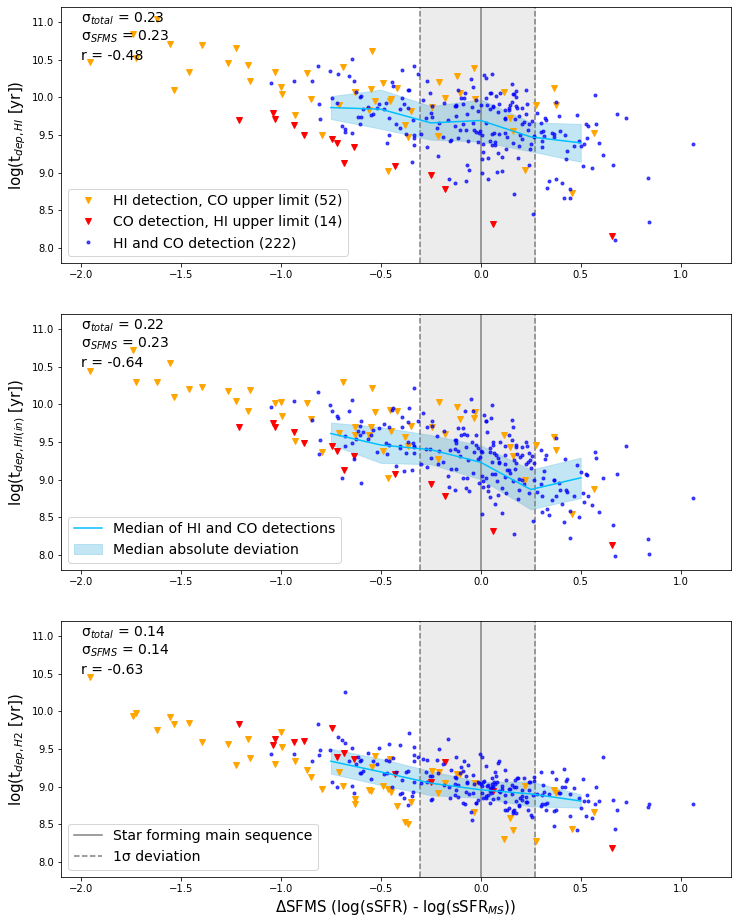

In [55]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(12,16))
# For t(dep) MHI (global)
plt.subplot(3,1,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='v', linestyle='none', label='HI detection, CO upper limit (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='v', linestyle='none', label='CO detection, HI upper limit (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], color='deepskyblue')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'skyblue', alpha = 0.5)

plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ$_{total}$ = %.2f' % ScatHIgl_SFMS, fontsize=14)
plt.text(-2, 10.75, 'σ$_{SFMS}$ = %.2f' % ScatHIgl_inSFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIgl_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MHI (optical)
plt.subplot(3,1,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], color='deepskyblue', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'skyblue', alpha = 0.5, label='Median absolute deviation')

plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ$_{total}$ = %.2f' % ScatHIin_SFMS, fontsize=14)
plt.text(-2, 10.75, 'σ$_{SFMS}$ = %.2f' % ScatHIin_inSFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIin_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MH2
plt.subplot(3,1,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], color='deepskyblue')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'skyblue', alpha = 0.5)

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ$_{total}$ = %.2f' % ScatH2_SFMS, fontsize=14)
plt.text(-2, 10.75, 'σ$_{SFMS}$ = %.2f' % ScatH2_inSFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrH2_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14);

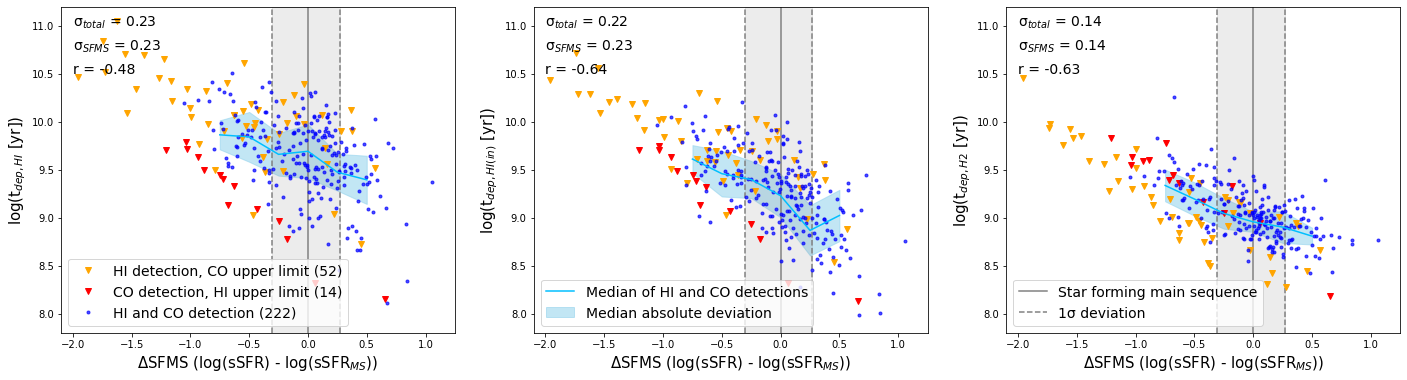

In [56]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(24,6))
# For t(dep) MHI (global)
plt.subplot(1,3,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='v', linestyle='none', label='HI detection, CO upper limit (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='v', linestyle='none', label='CO detection, HI upper limit (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], color='deepskyblue')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'skyblue', alpha = 0.5)

plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ$_{total}$ = %.2f' % ScatHIgl_SFMS, fontsize=14)
plt.text(-2, 10.75, 'σ$_{SFMS}$ = %.2f' % ScatHIgl_inSFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIgl_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MHI (optical)
plt.subplot(1,3,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], color='deepskyblue', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'skyblue', alpha = 0.5, label='Median absolute deviation')

plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ$_{total}$ = %.2f' % ScatHIin_SFMS, fontsize=14)
plt.text(-2, 10.75, 'σ$_{SFMS}$ = %.2f' % ScatHIin_inSFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIin_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MH2
plt.subplot(1,3,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], color='deepskyblue')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'skyblue', alpha = 0.5)

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ$_{total}$ = %.2f' % ScatH2_SFMS, fontsize=14)
plt.text(-2, 10.75, 'σ$_{SFMS}$ = %.2f' % ScatH2_inSFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrH2_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14);

12) Investigating any unusual galaxies within the depletion time plots

In [57]:
# Creating a subsection of the data that holds to the above condition that MH2 > MHI (optical region)
strange_gal_HIgl = lgtdep_HIgl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_gal_HIin = lgtdep_HIin_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_gal_H2 = lgtdep_H2_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_sSFMS_off = lgsSFMS_off_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_sSFMS = lgsSFMS_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_lgMSTAR = lgMSTAR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]
strange_sSFR = lgsSFR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)]

In [58]:
print(len(np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)[0]))

20


In [59]:
# Creating a subsection that holds to the above condition that MH2 > MHI (global)
stranger_gal_HIgl = lgtdep_HIgl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_gal_HIin = lgtdep_HIin_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_gal_H2 = lgtdep_H2_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_sSFMS_off = lgsSFMS_off_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
strangre_sSFMS = lgsSFMS_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_lgMSTAR = lgMSTAR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]
stranger_sSFR = lgsSFR_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)]

In [60]:
# Creating a subsection that contains the galaxies indide the SFMS

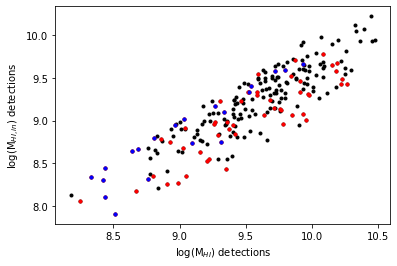

In [61]:
plt.plot(lgMHI_gl_det1, lgMHI_in_det1, 'k.')
plt.plot(lgMHI_gl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)], lgMHI_in_det1[np.where(lgtdep_H2_det1 > lgtdep_HIin_det1)], 'r.')
plt.plot(lgMHI_gl_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)], lgMHI_in_det1[np.where(lgtdep_H2_det1 > lgtdep_HIgl_det1)], 'b.')
plt.xlabel('log(M$_{HI}$) detections')
plt.ylabel('log(M$_{HI, in}$) detections');

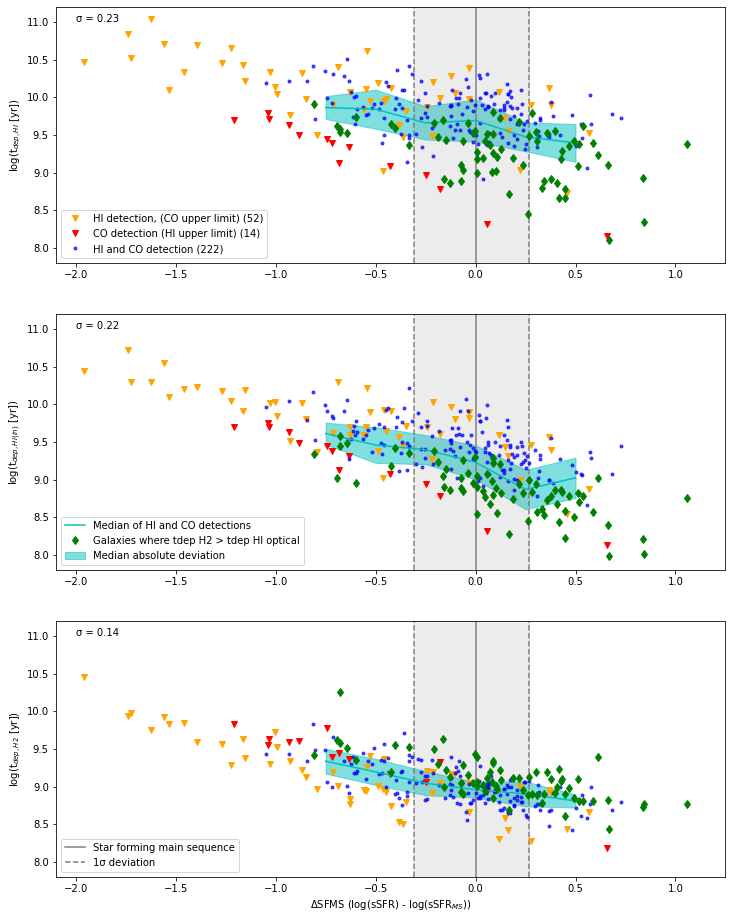

In [62]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(12,16))
# For t(dep) MHI (global)
plt.subplot(3,1,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='v', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(strange_sSFMS_off, strange_gal_HIgl, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, HI}$ [yr])')
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIgl_SFMS)
plt.legend(loc='lower left')

# For t(dep) MHI (optical)
plt.subplot(3,1,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')
plt.plot(strange_sSFMS_off, strange_gal_HIin, color='green', marker='d', linestyle='none', label='Galaxies where tdep H2 > tdep HI optical')

plt.ylabel('log(t$_{dep, HI (in)}$ [yr])')
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left')

# For t(dep) MH2
plt.subplot(3,1,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(strange_sSFMS_off, strange_gal_H2, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])')
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))')
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatH2_SFMS)
plt.legend(loc='lower left');

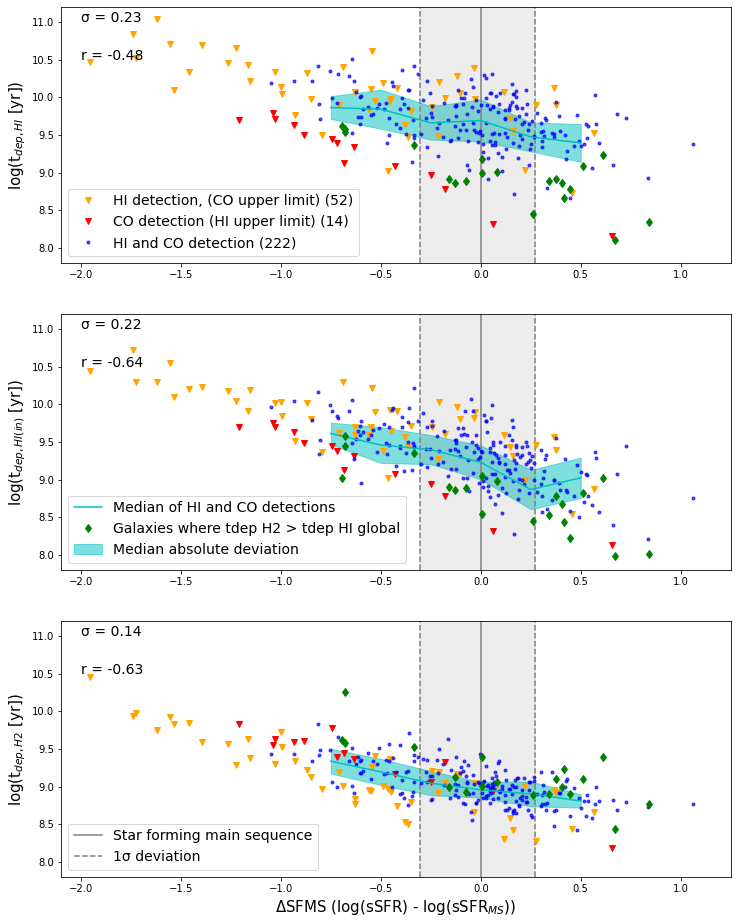

In [63]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(12,16))
# For t(dep) MHI (global)
plt.subplot(3,1,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='v', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(stranger_sSFMS_off, stranger_gal_HIgl, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIgl_SFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIgl_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MHI (optical)
plt.subplot(3,1,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')
plt.plot(stranger_sSFMS_off, stranger_gal_HIin, color='green', marker='d', linestyle='none', label='Galaxies where tdep H2 > tdep HI global')

plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIin_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MH2
plt.subplot(3,1,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'c', alpha = 0.5)
plt.plot(stranger_sSFMS_off, stranger_gal_H2, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatH2_SFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrH2_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14);

13) Investigating the surface density of the HI inside the optical region

In [64]:
# Finding the surface density of the HI inside the optical region
# We assume the surface density to be calculated as a 2D 'area'
# 'Reff_kpc' so we need convert it into parsecs
Reff_pc_det1 = (Reff_kpc_det1*1000)
Reff_pc_det3 = (Reff_kpc_det3*1000)
Reff_pc_det4 = (Reff_kpc_det4*1000)

Reff_area_det1 = np.pi*(Reff_pc_det1**2)
Reff_area_det3 = np.pi*(Reff_pc_det3**2)
Reff_area_det4 = np.pi*(Reff_pc_det4**2)

sigma_HIin_det1 = (10**lgMHI_in_det1) / Reff_area_det1
sigma_HIin_det3 = (10**lgMHI_in_det3) / Reff_area_det3
sigma_HIin_det4 = (10**lgMHI_in_det4) / Reff_area_det4

lgsigma_HIin_det1 = np.log10(sigma_HIin_det1)
lgsigma_HIin_det3 = np.log10(sigma_HIin_det3)
lgsigma_HIin_det4 = np.log10(sigma_HIin_det4)

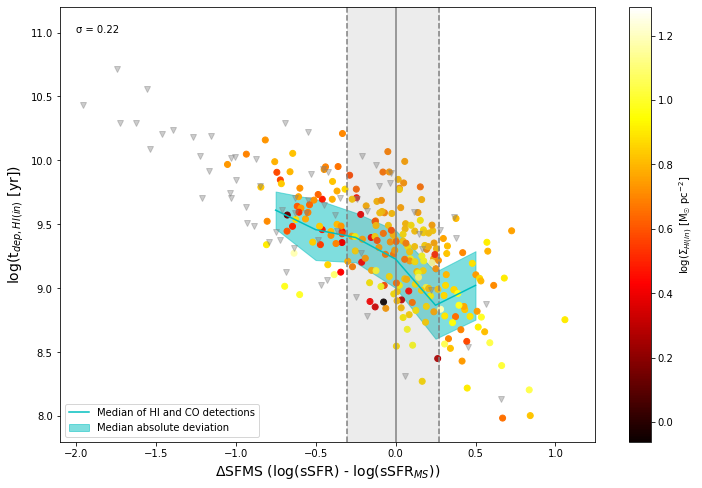

In [65]:
# Plotting the tdepletion time against SFMS offset for HI inside the optical region
# with the detections coloured by surface density
plt.figure(figsize=(12,8))
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')
plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')

plt.scatter(lgsSFMS_off_det1, lgtdep_HIin_det1, c = lgsigma_HIin_det1, cmap = 'hot')
plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.colorbar(label='log(Σ$_{HI (in)}$ [M$_{☉}$ pc$^{-2}$]', orientation='vertical')

plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=14)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=14)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS)
plt.legend(loc='lower left');

14) Looking at the surface density of M(cold gas), the sum of MHI and MH2

In [66]:
# If we define the total cold gas of a galaxy as the sum of MHI and MH2, we can find the surface density of Mcold
# Since we use R (optical) to find the surface area of the galaxy we will define M(cold, optical) = MHI(optical) + MH2
# M (cold gas, optical)
Mcold_in_det1 = (10**lgMHI_in_det1) + (10**lgMH2_det1)
Mcold_in_det3 = (10**lgMHI_in_det3) + (10**lgMH2_det3)
Mcold_in_det4 = (10**lgMHI_in_det4) + (10**lgMH2_det4)
# Finding the log
lgMcold_in_det1 = np.log10(Mcold_in_det1)
lgMcold_in_det3 = np.log10(Mcold_in_det3)
lgMcold_in_det4 = np.log10(Mcold_in_det4)

# Converting M(cold, optical) in surface density
sigma_coldin_det1 = (Mcold_in_det1) / Reff_area_det1
sigma_coldin_det3 = (Mcold_in_det3) / Reff_area_det3
sigma_coldin_det4 = (Mcold_in_det4) / Reff_area_det4

In [67]:
# Calculating the depletion times of Mcold (optical)
lgtdep_coldin_det1 = np.log10(Mcold_in_det1 / ((10**lgsSFR_det1) * (10**lgMSTAR_det1)))
lgtdep_coldin_det3 = np.log10(Mcold_in_det3 / ((10**lgsSFR_det3) * (10**lgMSTAR_det3)))
lgtdep_coldin_det4 = np.log10(Mcold_in_det4 / ((10**lgsSFR_det4) * (10**lgMSTAR_det4)))

In [68]:
# Finding the median and MAD of the depletion time for M(cold)
# Arrays for the bins
SFMSbins = np.linspace(-0.75, 0.75, 7)

# Array of zeroes to store the median of each bin
SFMS_coldin_median = np.zeros(len(SFMSbins))
SFMS_coldin_MAD = np.zeros(len(SFMSbins))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(SFMSbins) -1):
  # Median and MAD for the SFMS of t(dep) for MHI (global)
  SFMS_coldin_median[i] = np.median(lgtdep_coldin_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])
  SFMS_coldin_MAD[i] = stats.median_abs_deviation(lgtdep_coldin_det1[np.where((lgsSFMS_off_det1 >= SFMSbins[i]) & (lgsSFMS_off_det1 <= SFMSbins[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
SFMS_coldin_pMAD = SFMS_coldin_median + SFMS_coldin_MAD
SFMS_coldin_nMAD = SFMS_coldin_median - SFMS_coldin_MAD

# Scatter for tdep (cold gas)
Scatcoldin_SFMS = np.mean(SFMS_coldin_MAD[:-1])
# Correlation for tdep (cold gas)
CorrCold_SFMS = np.corrcoef(lgsSFMS_off_det1, lgtdep_coldin_det1)[0]

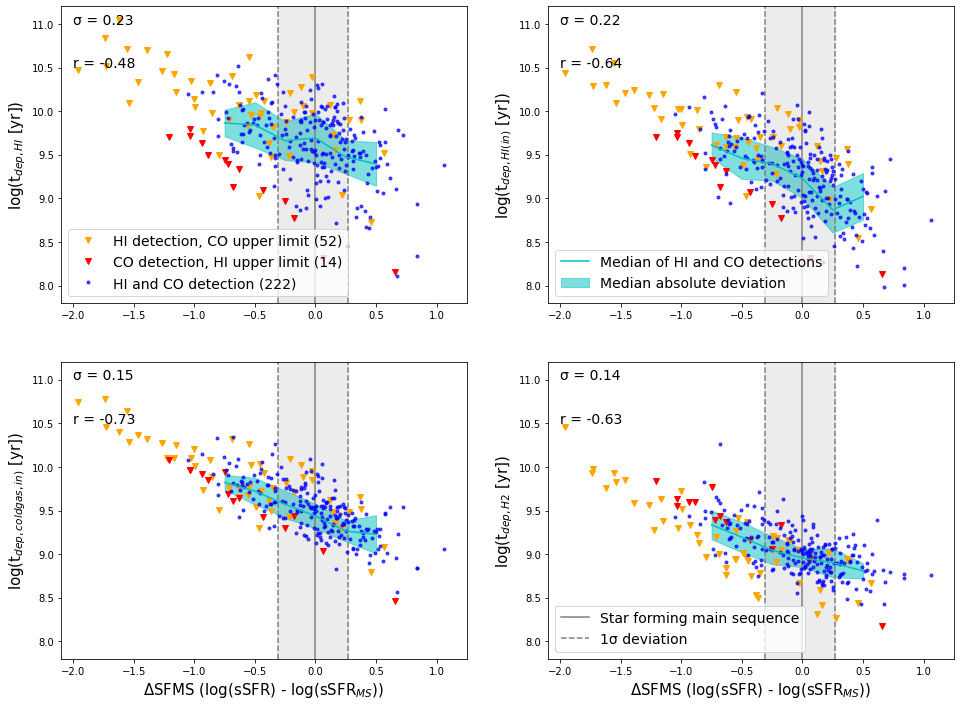

In [69]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(16,12))
# For t(dep) MHI (global)
plt.subplot(2,2,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='v', linestyle='none', label='HI detection, CO upper limit (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='v', linestyle='none', label='CO detection, HI upper limit (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'c', alpha = 0.5)

plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIgl_SFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIgl_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MHI (optical)
plt.subplot(2,2,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')

plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrHIin_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) Mcold
plt.subplot(2,2,3)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_coldin_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_coldin_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_coldin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_coldin_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_coldin_nMAD[:-1], SFMS_coldin_pMAD[:-1], color= 'c', alpha = 0.5)

plt.ylabel('log(t$_{dep, cold gas, in)}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % Scatcoldin_SFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrCold_SFMS[1], fontsize=14)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)

# For t(dep) MH2
plt.subplot(2,2,4)
plt.axvline(x=0, color='grey', linestyle='-', label='Star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], 'c-')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'c', alpha = 0.5)

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatH2_SFMS, fontsize=14)
plt.text(-2, 10.5, 'r = %.2f' % CorrH2_SFMS[1], fontsize=14)
plt.legend(loc='lower left', fontsize=14);

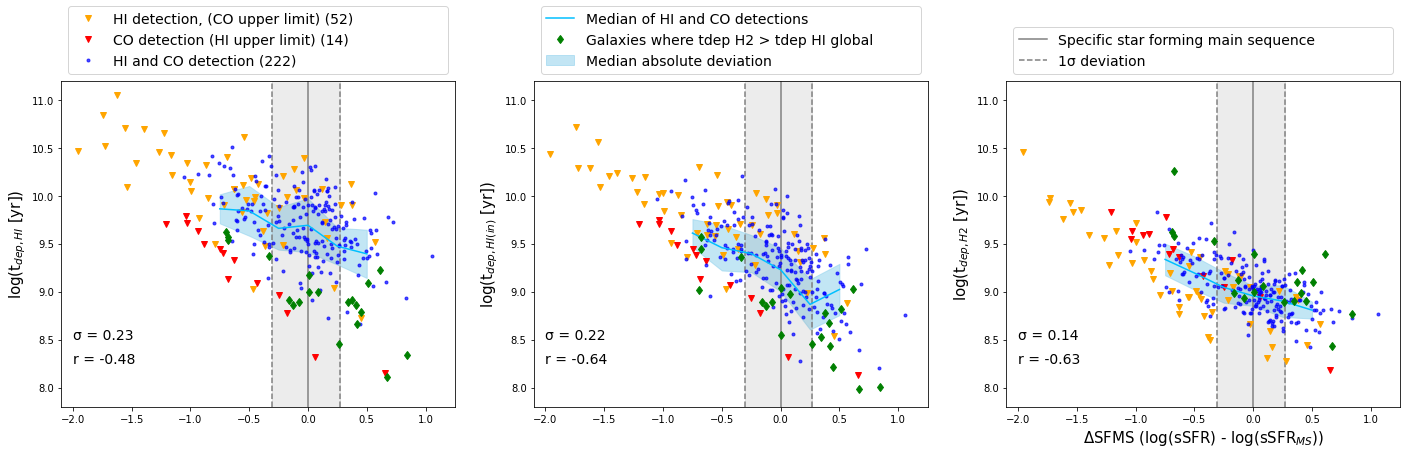

In [70]:
# Plotting the delta SFMS (x-axis) against the three depletion times for each gas
plt.figure(figsize=(24,6))
# For t(dep) MHI (global)
plt.subplot(1,3,1)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIgl_det3, 'orange', marker='v', linestyle='none', label='HI detection, (CO upper limit) (52)')
plt.plot(lgsSFMS_off_det4, lgtdep_HIgl_det4, 'red', marker='v', linestyle='none', label='CO detection (HI upper limit) (14)')
plt.plot(lgsSFMS_off_det1, lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none', label='HI and CO detection (222)', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIgl_median[:-1], color='deepskyblue')
plt.fill_between(SFMSbins[:-1], SFMS_HIgl_nMAD[:-1], SFMS_HIgl_pMAD[:-1], color= 'skyblue', alpha = 0.5)
plt.plot(stranger_sSFMS_off, stranger_gal_HIgl, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 8.5, 'σ = %.2f' % ScatHIgl_SFMS, fontsize=14)
plt.text(-2, 8.25, 'r = %.2f' % CorrHIgl_SFMS[1], fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14);

# For t(dep) MHI (optical)
plt.subplot(1,3,2)
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_HIin_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_HIin_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_HIin_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_HIin_median[:-1], color='deepskyblue', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_HIin_nMAD[:-1], SFMS_HIin_pMAD[:-1], color= 'skyblue', alpha = 0.5, label='Median absolute deviation')
plt.plot(stranger_sSFMS_off, stranger_gal_HIin, color='green', marker='d', linestyle='none', label='Galaxies where tdep H2 > tdep HI global')

plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 8.5, 'σ = %.2f' % ScatHIin_SFMS, fontsize=14)
plt.text(-2, 8.25, 'r = %.2f' % CorrHIin_SFMS[1], fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14)

# For t(dep) MH2
plt.subplot(1,3,3)
plt.axvline(x=0, color='grey', linestyle='-', label='Specific star forming main sequence')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--', label='1σ deviation') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')

plt.plot(lgsSFMS_off_det3, lgtdep_H2_det3, 'orange', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det4, lgtdep_H2_det4, 'red', marker='v', linestyle='none')
plt.plot(lgsSFMS_off_det1, lgtdep_H2_det1, 'blue', marker='.', linestyle='none', alpha=0.7)

plt.plot(SFMSbins[:-1], SFMS_H2_median[:-1], color='deepskyblue')
plt.fill_between(SFMSbins[:-1], SFMS_H2_nMAD[:-1], SFMS_H2_pMAD[:-1], color= 'skyblue', alpha = 0.5)
plt.plot(stranger_sSFMS_off, stranger_gal_H2, color='green', marker='d', linestyle='none')

plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.ylim(7.8, 11.2)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=15)
plt.xlim(-2.1, 1.25)
plt.text(-2, 8.25, 'r = %.2f' % CorrH2_SFMS[1], fontsize=14)
plt.text(-2, 8.5, 'σ = %.2f' % ScatH2_SFMS, fontsize=14)
plt.legend(bbox_to_anchor=(0,1,1,0), loc='lower left', mode='expand', fontsize=14);

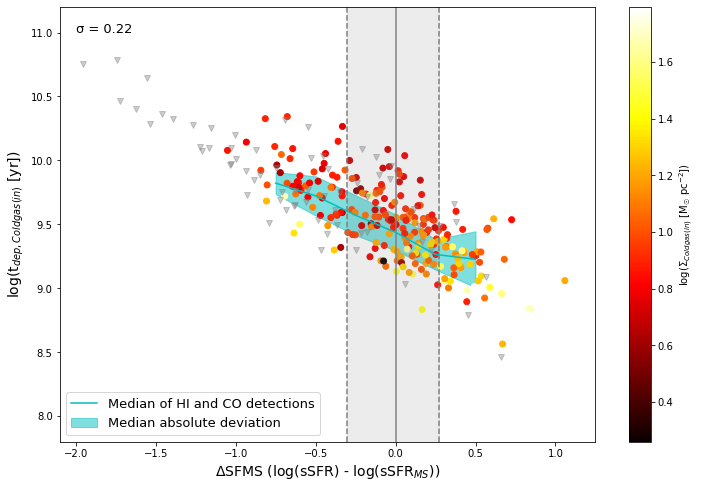

In [71]:
# Plotting the tdepletion time against SFMS offset for M(cold gas) the optical region
# with the detections coloured by surface density
plt.figure(figsize=(12,8))
plt.axvline(x=0, color='grey', linestyle='-')
plt.axvline(x=np.mean(lgsSFMS_off_dw), color='grey', linestyle='--') 
plt.axvline(x=np.mean(lgsSFMS_off_up), color='grey', linestyle='--')
plt.axvspan(xmin = np.mean(lgsSFMS_off_dw), xmax = np.mean(lgsSFMS_off_up), alpha = 0.15, color = 'grey')
plt.plot(SFMSbins[:-1], SFMS_coldin_median[:-1], 'c-', label='Median of HI and CO detections')
plt.fill_between(SFMSbins[:-1], SFMS_coldin_nMAD[:-1], SFMS_coldin_pMAD[:-1], color= 'c', alpha = 0.5, label='Median absolute deviation')

plt.scatter(lgsSFMS_off_det1, lgtdep_coldin_det1, c = np.log10(sigma_coldin_det1), cmap = 'hot')
plt.plot(lgsSFMS_off_det3, lgtdep_coldin_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgsSFMS_off_det4, lgtdep_coldin_det4, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.colorbar(label='log(Σ$_{Cold gas (in)}$ [M$_{☉}$ pc$^{-2}$])', orientation='vertical')

plt.ylabel('log(t$_{dep, Cold gas (in)}$ [yr])', fontsize=14)
plt.xlabel('ΔSFMS (log(sSFR) - log(sSFR$_{MS}$))', fontsize=14)
plt.ylim(7.8, 11.2)
plt.xlim(-2.1, 1.25)
plt.text(-2, 11, 'σ = %.2f' % ScatHIin_SFMS, fontsize=13)
plt.legend(loc='lower left', fontsize=13);

15) Investigating the surface density, when plotting the depletion times against the stellar masses

In [72]:
# Finding the surface density of HI (global)
# Finding the surface density of the HI inside the optical region
# We assume the surface density to be calculated as a 2D 'area'
RHI_pc_det1 = (RHI_kpc_det1*1000)
RHI_pc_det3 = (RHI_kpc_det3*1000)
RHI_pc_det4 = (RHI_kpc_det4*1000)

RHI_area_det1 = np.pi*(RHI_pc_det1**2)
RHI_area_det3 = np.pi*(RHI_pc_det3**2)
RHI_area_det4 = np.pi*(RHI_pc_det4**2)

sigma_HIgl_det1 = (10**lgMHI_gl_det1) / RHI_area_det1
sigma_HIgl_det3 = (10**lgMHI_gl_det3) / RHI_area_det3
sigma_HIgl_det4 = (10**lgMHI_gl_det4) / RHI_area_det4

In [73]:
print(lgMHI_gl_det1[0:11])
print(lgMHI_in_det1[0:11])
print(lgMH2_det1[0:11])

[ 8.93900013 10.25        8.98700047 10.26000023  9.72000027  9.69999981
  9.95800018  9.40499973  9.22000027  9.15499973  9.42000008]
[8.90511148 9.54767726 8.64358316 9.81155691 9.47219077 9.49681023
 9.00303842 8.87111846 9.07978122 8.76771299 8.84654767]
[8.767027 9.152241 8.206711 9.038205 9.086422 8.583894 9.068446 8.637632
 8.787152 8.236977 8.923811]


In [74]:
# Finding the surface density of H2
sigma_H2_det1 = (10**lgMH2_det1) / Reff_area_det1
sigma_H2_det3 = (10**lgMH2_det3) / Reff_area_det3
sigma_H2_det4 = (10**lgMH2_det4) / Reff_area_det4

In [75]:
# Finding the median lines of the cold gas against Mstar
# Arrays for the bins
MSTARbins = np.linspace(9, 11.25, 10)

# Array of zeroes to store the median of each bin
MSTAR_coldin_median = np.zeros(len(MSTARbins))
MSTAR_coldin_MAD = np.zeros(len(MSTARbins))

# Using a for loop to iterate over the median values for each of the bins
for i in range(len(MSTARbins) -1):
  # Median and MAD for the SFMS of t(dep) for MHI (global)
  MSTAR_coldin_median[i] = np.median(lgtdep_coldin_det1[np.where((lgMSTAR_det1 >= MSTARbins[i]) & (lgMSTAR_det1 <= MSTARbins[i+1]))])
  MSTAR_coldin_MAD[i] = stats.median_abs_deviation(lgtdep_coldin_det1[np.where((lgMSTAR_det1 >= MSTARbins[i]) & (lgMSTAR_det1 <= MSTARbins[i+1]))])

# Working out the upper and lower bounds of the median absolute deviation
MSTAR_coldin_pMAD = MSTAR_coldin_median + MSTAR_coldin_MAD
MSTAR_coldin_nMAD = MSTAR_coldin_median - MSTAR_coldin_MAD

# Scatter for tdep (cold gas)
Scatcoldin_MSTAR = np.mean(MSTAR_coldin_MAD[:-1])

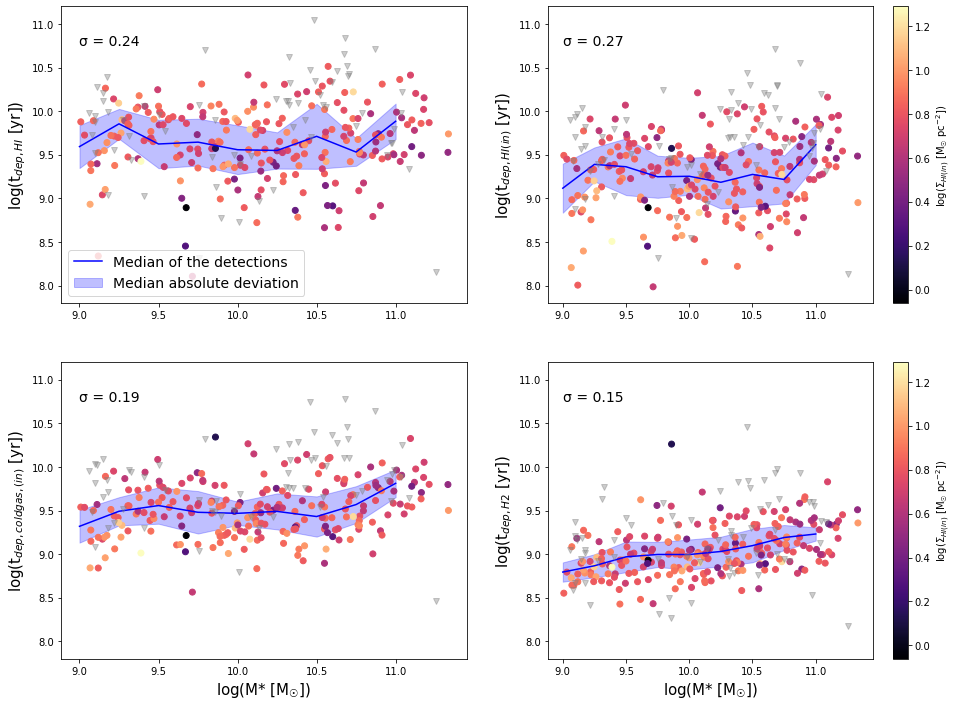

In [76]:
plt.figure(figsize=(16,12))
# For t(dep) MHI (global)
plt.subplot(2,2,1)
plt.plot(bins_Mstar[:-1], tdep_HIglmedian_Mstar[:-1], 'blue', label='Median of the detections')
plt.fill_between(bins_Mstar[:-1], tdep_HIglnMAD_Mstar[:-1], tdep_HIglpMAD_Mstar[:-1], color= 'b', alpha = 0.25, label='Median absolute deviation')

plt.scatter(lgMSTAR_det1, lgtdep_HIgl_det1, c = np.log10(sigma_HIin_det1), cmap = 'magma')
plt.plot(lgMSTAR_det3, lgtdep_HIgl_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_HIgl_det4, 'grey', marker='v', linestyle='none', alpha=0.4)

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % ScatHIgl_Mstar, fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MHI (optical)
plt.subplot(2,2,2)
plt.plot(bins_Mstar[:-1], tdep_HIinmedian_Mstar[:-1], 'blue')
plt.fill_between(bins_Mstar[:-1], tdep_HIinnMAD_Mstar[:-1], tdep_HIinpMAD_Mstar[:-1], color= 'b', alpha = 0.25)

plt.scatter(lgMSTAR_det1, lgtdep_HIin_det1, c = np.log10(sigma_HIin_det1), cmap = 'magma')
plt.plot(lgMSTAR_det3, lgtdep_HIin_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_HIin_det4, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.colorbar(label='log(Σ$_{HI (in)}$ [M$_{☉}$ pc$^{-2}$])', orientation='vertical')

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % ScatHIin_Mstar, fontsize=14)

# For t(dep) Mcold
plt.subplot(2,2,3)
plt.plot(MSTARbins[:-1], MSTAR_coldin_median[:-1], 'blue')
plt.fill_between(MSTARbins[:-1], MSTAR_coldin_nMAD[:-1], MSTAR_coldin_pMAD[:-1], color= 'b', alpha = 0.25)

plt.scatter(lgMSTAR_det1, lgtdep_coldin_det1, c = np.log10(sigma_HIin_det1), cmap = 'magma')
plt.plot(lgMSTAR_det3, lgtdep_coldin_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_coldin_det4, 'grey', marker='v', linestyle='none', alpha=0.4)

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, cold gas, (in)}$ [yr])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % Scatcoldin_MSTAR, fontsize=14)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)

# For t(dep) MH2
plt.subplot(2,2,4)
plt.plot(bins_Mstar[:-1], tdep_H2median_Mstar[:-1], 'blue')
plt.fill_between(bins_Mstar[:-1], tdep_H2nMAD_Mstar[:-1], tdep_H2pMAD_Mstar[:-1], color= 'b', alpha = 0.25)

plt.scatter(lgMSTAR_det1, lgtdep_H2_det1, c = np.log10(sigma_HIin_det1), cmap = 'magma')
plt.plot(lgMSTAR_det3, lgtdep_H2_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_H2_det4, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.colorbar(label='log(Σ$_{HI (in)}$ [M$_{☉}$ pc$^{-2}$])', orientation='vertical')

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % ScatH2_Mstar, fontsize=14);

16) Binning the surface densities of the galaxies, looking at the extremes of the surface density data

In [77]:
# Selecting only those galaxies with log(Σ{HI (in)}) >= 0.2 or with log(Σ{HI (in)}) =< 1
# Stellar mass
highSD_lgMSTAR_det1 = lgMSTAR_det1[np.where(lgsigma_HIin_det1 >= 1)]
lowSD_lgMSTAR_det1 = lgMSTAR_det1[np.where(lgsigma_HIin_det1 <= 0.4)]
# HI depletion time
highSD_lgtdep_HIgl_det1 = lgtdep_HIgl_det1[np.where(lgsigma_HIin_det1 >= 1)]
lowSD_lgtdep_HIgl_det1 = lgtdep_HIgl_det1[np.where(lgsigma_HIin_det1 <= 0.4)]
# HI (in) depletion time
highSD_lgtdep_HIin_det1 = lgtdep_HIin_det1[np.where(lgsigma_HIin_det1 >= 1)]
lowSD_lgtdep_HIin_det1 = lgtdep_HIin_det1[np.where(lgsigma_HIin_det1 <= 0.4)]
# Cold gas (HI (in) + H2) depletion time
highSD_lgtdep_coldin_det1 = lgtdep_coldin_det1[np.where(lgsigma_HIin_det1 >= 1)]
lowSD_lgtdep_coldin_det1 = lgtdep_coldin_det1[np.where(lgsigma_HIin_det1 <= 0.4)]
# H2 depletion time
highSD_lgtdep_H2_det1 = lgtdep_H2_det1[np.where(lgsigma_HIin_det1 >= 1)]
lowSD_lgtdep_H2_det1 = lgtdep_H2_det1[np.where(lgsigma_HIin_det1 <= 0.4)]

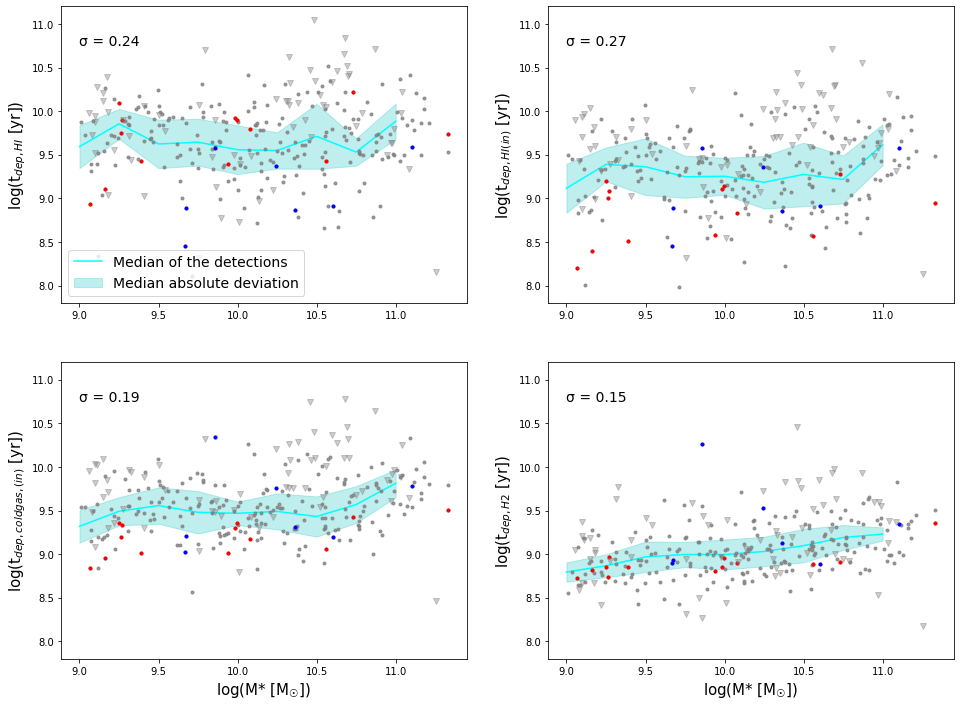

In [82]:
# Plotting the same graph as above but only the galaxies fulfilling the conditions above will be coloured
plt.figure(figsize=(16,12))
# For t(dep) MHI (global)
plt.subplot(2,2,1)
plt.plot(bins_Mstar[:-1], tdep_HIglmedian_Mstar[:-1], 'cyan', label='Median of the detections')
plt.fill_between(bins_Mstar[:-1], tdep_HIglnMAD_Mstar[:-1], tdep_HIglpMAD_Mstar[:-1], color= 'c', alpha = 0.25, label='Median absolute deviation')

plt.plot(lgMSTAR_det1, lgtdep_HIgl_det1, 'grey', marker='.', linestyle='none', alpha=0.8)
plt.plot(highSD_lgMSTAR_det1, highSD_lgtdep_HIgl_det1, 'red', marker='.', linestyle='none')
plt.plot(lowSD_lgMSTAR_det1, lowSD_lgtdep_HIgl_det1, 'blue', marker='.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_HIgl_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_HIgl_det4, 'grey', marker='v', linestyle='none', alpha=0.4)

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, HI}$ [yr])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % ScatHIgl_Mstar, fontsize=14)
plt.legend(loc='lower left', fontsize=14)

# For t(dep) MHI (optical)
plt.subplot(2,2,2)
plt.plot(bins_Mstar[:-1], tdep_HIinmedian_Mstar[:-1], 'cyan')
plt.fill_between(bins_Mstar[:-1], tdep_HIinnMAD_Mstar[:-1], tdep_HIinpMAD_Mstar[:-1], color= 'c', alpha = 0.25)

plt.plot(lgMSTAR_det1, lgtdep_HIin_det1, 'grey', marker='.', linestyle='none', alpha=0.8)
plt.plot(highSD_lgMSTAR_det1, highSD_lgtdep_HIin_det1, 'red', marker='.', linestyle='none')
plt.plot(lowSD_lgMSTAR_det1, lowSD_lgtdep_HIin_det1, 'blue', marker='.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_HIin_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_HIin_det4, 'grey', marker='v', linestyle='none', alpha=0.4)

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, HI (in)}$ [yr])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % ScatHIin_Mstar, fontsize=14)

# For t(dep) Mcold
plt.subplot(2,2,3)
plt.plot(MSTARbins[:-1], MSTAR_coldin_median[:-1], 'cyan')
plt.fill_between(MSTARbins[:-1], MSTAR_coldin_nMAD[:-1], MSTAR_coldin_pMAD[:-1], color= 'c', alpha = 0.25)

plt.plot(lgMSTAR_det1, lgtdep_coldin_det1, 'grey', marker='.', linestyle='none', alpha=0.8)
plt.plot(highSD_lgMSTAR_det1, highSD_lgtdep_coldin_det1, 'red', marker='.', linestyle='none')
plt.plot(lowSD_lgMSTAR_det1, lowSD_lgtdep_coldin_det1, 'blue', marker='.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_coldin_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_coldin_det4, 'grey', marker='v', linestyle='none', alpha=0.4)

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, cold gas, (in)}$ [yr])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % Scatcoldin_MSTAR, fontsize=14)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)

# For t(dep) MH2
plt.subplot(2,2,4)
plt.plot(bins_Mstar[:-1], tdep_H2median_Mstar[:-1], 'cyan')
plt.fill_between(bins_Mstar[:-1], tdep_H2nMAD_Mstar[:-1], tdep_H2pMAD_Mstar[:-1], color= 'c', alpha = 0.25)

plt.plot(lgMSTAR_det1, lgtdep_H2_det1, 'grey', marker='.', linestyle='none', alpha=0.8)
plt.plot(highSD_lgMSTAR_det1, highSD_lgtdep_H2_det1, 'red', marker='.', linestyle='none')
plt.plot(lowSD_lgMSTAR_det1, lowSD_lgtdep_H2_det1, 'blue', marker='.', linestyle='none')
plt.plot(lgMSTAR_det3, lgtdep_H2_det3, 'grey', marker='v', linestyle='none', alpha=0.4)
plt.plot(lgMSTAR_det4, lgtdep_H2_det4, 'grey', marker='v', linestyle='none', alpha=0.4)

plt.ylim(7.8, 11.2)
plt.ylabel('log(t$_{dep, H2}$ [yr])', fontsize=15)
plt.xlabel('log(M* [M$_{☉}$])', fontsize=15)
plt.text(9, 10.75, 'σ = %.2f' % ScatH2_Mstar, fontsize=14);

17) Writing an output file with some of the key data for the galaxies with larger MHI (optical) depletion times than MH2 depletion times

In [79]:
low_H2HIGASS = GASS_det1[np.where(lgMH2_det1 > lgMHI_gl_det1)]
low_H2HIRA = RA_det1[np.where(lgMH2_det1 > lgMHI_gl_det1)]
low_H2HIDEC = DEC_det1[np.where(lgMH2_det1 > lgMHI_gl_det1)]

In [80]:
#np.savetxt('low_HIdepletion_times.txt', np.c_[low_GASS, low_RA, low_DEC, strange_gal_HIgl, strange_gal_HIin, strange_gal_H2], header='GASSID  RA  DEC HIgl  HIin  H2',fmt='%s', delimiter='\t')

In [81]:
#np.savetxt('low_H2HIgldepletion_coords.txt', np.c_[low_H2HIGASS, low_H2HIRA, low_H2HIDEC], header='GASSID  RA  DEC',fmt='%s', delimiter='\t')